## Using Deep Learning to Build an 🪐 Exoplanet 🪐 Transit Detection Model

### Introduction

Detecting exoplanets using the transit method became extremely popular with NASA's Kepler mission, and has stayed popular with missions like the Transiting Exoplanet Systems Satellite (TESS) have been providing lots of data on distant star's light intensity (also known as flux) fluctuations. The transit method of exoplanet detection involves observing the flux coming from a distant star and checking for any fluctuations including dips or dimming. If an object passes between the observer and the star, the flux seen by the observer will dip. So, if an exoplanet that orbits a star passes in front of the star, we will see the flux coming from that star drop. A visualization of this can be seen below.


![Exoplanet Transit Detection Method from JWST](jwst_transit.png)


As of today, 3,986 exoplanets have been detected with this method.

The James Webb Space Telescope (JWST) has also utilized the transit method, as seen above, and the upcoming Nancy Grace Roman Telescope will utilize the transit method as well to find exoplanets. With the amount of data that is coming in and may be coming in the future, it could be extremely useful to automate the process of searching flux data for these characteristic fluctuations that lead to exoplanet detections.

In this notebook, I will build an Artifical Neural Network (ANN) to hopefully classify stellar flux time series data into two classes: exoplanet detected from transit (2) or no exoplanet detected (1). 

Training and testing data is obtained from the Kepler mission, specifically downloaded from [this Kaggle dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?select=exoTest.csv). Data is already cleaned and preprocessed and split into training and testing segments. There are 5 confirmed exoplanet host stars and 565 normal stars in testing data and 37 confirmed exoplanet host stars and 5050 normal stars in training data.

### Importing Tools & Libraries

Let's start by importing the tools and libraries that we will use for data analysis, visualizations, and modeling.

In [1]:
import warnings

# data processing tools
import numpy as np
import pandas as pd

# data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns 

# Preprocessing & Metrics tools
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Machine learning models and tools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # K nearest neighbors classifier
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.tree import DecisionTreeClassifier # Decision tree classifier
from sklearn.ensemble import RandomForestClassifier # Random forest classifier, creates multiple decision trees

# Deep learning models and tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import SGD

warnings.filterwarnings('ignore') #ignoring warnings
print(tf.__version__)

2023-05-09 21:47:45.587866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


Now let's load in our data

In [2]:
DATA_PATH = "./transit_data"
testing_data_path = f"{DATA_PATH}/exoTest.csv"
training_data_path = f"{DATA_PATH}/exoTrain.csv"

test_data = pd.read_csv(testing_data_path)
train_data = pd.read_csv(training_data_path)

print(test_data.head(3))
print(train_data.head(3))

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6   FLUX.7   
0      2   119.88   100.21    86.46    48.68    46.12    39.39    18.57  \
1      2  5736.59  5699.98  5717.16  5692.73  5663.83  5631.16  5626.39   
2      2   844.48   817.49   770.07   675.01   605.52   499.45   440.77   

    FLUX.8   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191   
0     6.98     6.63  ...      14.52      19.29      14.44      -1.62  \
1  5569.47  5550.44  ...    -581.91    -984.09   -1230.89   -1600.45   
2   362.95   207.27  ...      17.82     -51.66     -48.29     -59.99   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      13.33      45.50      31.93      35.78     269.43      57.72  
1   -1824.53   -2061.17   -2265.98   -2366.19   -2294.86   -2034.72  
2     -82.10    -174.54     -95.23    -162.68     -36.79      30.63  

[3 rows x 3198 columns]
   LABEL  FLUX.1  FLUX.2  FLUX.3  FLUX.4  FLUX.5  FLUX.6  FLUX.7  FLUX.8   
0      2   93.85   83.81   20

### Preprocessing Part 1

Let's do some preprocessing. We'll first change the labels from 1 or 2 to 0 or 1 to reflect binary values. Then we'll look for null data and impute that, and make sure we understand our other columns.

In [3]:
# Changing labels from 1, 2 to 0, 1
test_data['LABEL'] = test_data['LABEL'].replace({1: 0, 2: 1})
train_data['LABEL'] = train_data['LABEL'].replace({1: 0, 2: 1})

print(test_data.head(2))
print(train_data.head(2))

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6   FLUX.7   
0      1   119.88   100.21    86.46    48.68    46.12    39.39    18.57  \
1      1  5736.59  5699.98  5717.16  5692.73  5663.83  5631.16  5626.39   

    FLUX.8   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191   
0     6.98     6.63  ...      14.52      19.29      14.44      -1.62  \
1  5569.47  5550.44  ...    -581.91    -984.09   -1230.89   -1600.45   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      13.33      45.50      31.93      35.78     269.43      57.72  
1   -1824.53   -2061.17   -2265.98   -2366.19   -2294.86   -2034.72  

[2 rows x 3198 columns]
   LABEL  FLUX.1  FLUX.2  FLUX.3  FLUX.4  FLUX.5  FLUX.6  FLUX.7  FLUX.8   
0      1   93.85   83.81   20.10  -26.98  -39.56 -124.71 -135.18  -96.27  \
1      1  -38.88  -33.83  -58.54  -40.09  -79.31  -72.81  -86.55  -85.33   

   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  FLUX.3192   
0  -79.89  ...     -

In [4]:
# Checking for null values
if test_data.isnull().values.any():
    print("There are null values in the Test DataFrame")
else:
    print("There are no null values in the Test DataFrame")

if train_data.isnull().values.any():
    print("There are null values in the Train DataFrame")
else:
    print("There are no null values in the Train DataFrame")

There are no null values in the Test DataFrame
There are no null values in the Train DataFrame


In [5]:
print('TRAIN INFO:\n')
print(train_data.info())
print('\nTEST INFO:\n')
print(test_data.info())

TRAIN INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB
None

TEST INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 13.9 MB
None


In [6]:
print(train_data['LABEL'].value_counts())
print(test_data['LABEL'].value_counts())

LABEL
0    5050
1      37
Name: count, dtype: int64
LABEL
0    565
1      5
Name: count, dtype: int64


We can see that the first column is a label signifying 0 (not an exoplanet detection) or 1 (an exoplanet detection). The remaining columns are flux densities and the sequence from FLUX.1 to FLUX.3197 is a sequence of fluxes from that star over time. We can also see train data has 5,050 non exoplanet data points and 37 exoplanet data points while test data has 565 and 5 respectively.

### Visualizations

Let's plot out one of these light curves so we can visualize the change of flux over time for both a non-exoplanet detection and an exoplanet detection.

In [7]:
NON_EXOPLANET_TEST = (test_data['LABEL'] == 0)
EXOPLANET_TEST = (test_data['LABEL'] == 1)
test_nonexoplanet = test_data[NON_EXOPLANET_TEST]
test_exoplanet = test_data[EXOPLANET_TEST]

NON_EXOPLANET_TRAIN = (train_data['LABEL'] == 0)
EXOPLANET_TRAIN = (train_data['LABEL'] == 1)
train_nonexoplanet = train_data[NON_EXOPLANET_TRAIN]
train_exoplanet = train_data[EXOPLANET_TRAIN]

Text(0.5, 0.04, 'Time')

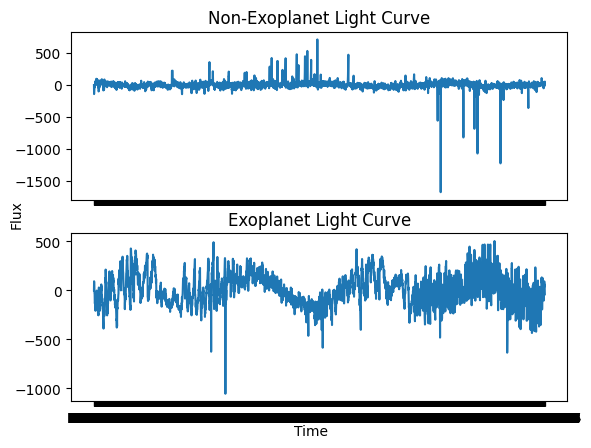

In [8]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_nonexoplanet.iloc[0])
ax1.title.set_text('Non-Exoplanet Light Curve')
ax2.plot(train_exoplanet.iloc[0])
ax2.title.set_text('Exoplanet Light Curve')
fig.text(0.04, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Time', ha='center')

Text(0.5, 0.04, 'Time')

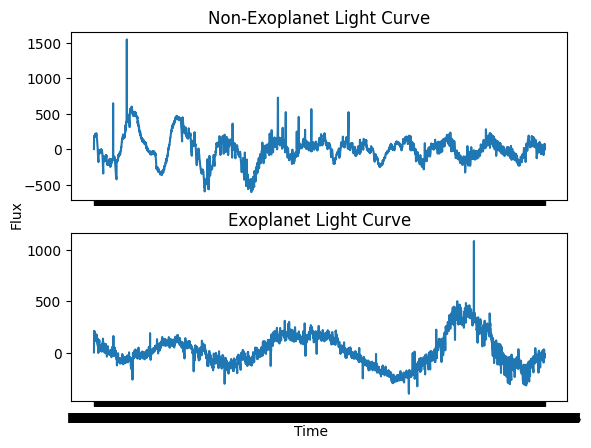

In [9]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_nonexoplanet.iloc[5])
ax1.title.set_text('Non-Exoplanet Light Curve')
ax2.plot(train_exoplanet.iloc[5])
ax2.title.set_text('Exoplanet Light Curve')
fig.text(0.04, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Time', ha='center')

Text(0.5, 0.04, 'Time')

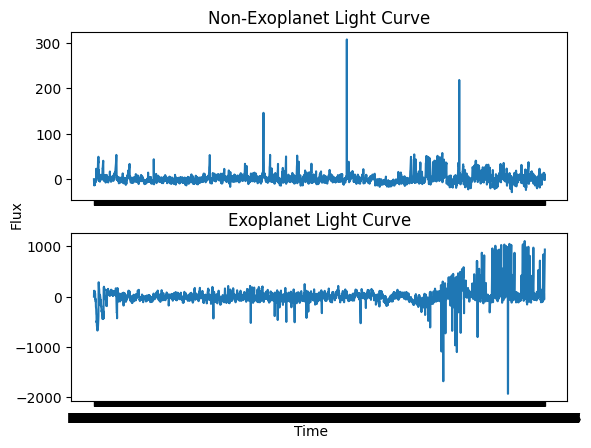

In [10]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_nonexoplanet.iloc[10])
ax1.title.set_text('Non-Exoplanet Light Curve')
ax2.plot(train_exoplanet.iloc[10])
ax2.title.set_text('Exoplanet Light Curve')
fig.text(0.04, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Time', ha='center')

We can see there may be some discrepancies amongst our non-exoplanet light curves and exoplanet light curves. However, it is not immediately apparent. Also, our data is not normalized, so there are big differences between the different plots we see, whether they have the same classification or not. Normalization will be an important step before we feed our data into any models. Let's normalize our data, then look at some comparisons.

### Preprocessing Part 2

To make the right decision about the scaling/normalization technique to use, we need to assess the spread of our data. Too many outliers will really mess up a minmaxscaler. But if the outliers are essential to our data, we need to keep them and find another way of scaling, like logarithmic transformation or SkLearn's RobustScaler. Let's explore the range of our data first.

In [11]:
min_flux = train_data.iloc[:, 1:].min(axis=1).min()
max_flux = train_data.iloc[:, 1:].max(axis=1).max()
print(f'Min flux: {min_flux}, Max flux: {max_flux}')
print(f'Total range: {max_flux - min_flux}')

Min flux: -2385019.12, Max flux: 4299288.0
Total range: 6684307.12


We see that our data has a range of over 6 million. That's pretty intense. Let's see what the range across each row looks like.

In [12]:
# compute the range of data across each row
row_range = train_data.apply(lambda row: row.max() - row.min(), axis=1)
print(f'Row range min: {row_range.min()} \n Row range max: {row_range.max()} \n Row range average: {row_range.mean()}')
print(f'Number of ranges above 1 million: {(row_range > 1000000).sum()}')
print(f'Number of ranges above 500,000: {(row_range > 500000).sum()}')
print(f'Number of ranges above 250,000: {(row_range > 250000).sum()}')
print(f'Number of ranges above 12,500: {(row_range > 12500).sum()}')
print(f'Number of ranges below 100: {(row_range < 100).sum()}')
print(f'Number of ranges below 50: {(row_range < 50).sum()}')
print(f'Number of ranges below 25: {(row_range < 25).sum()}')

Row range min: 18.57 
 Row range max: 5026643.87 
 Row range average: 8691.352811087085
Number of ranges above 1 million: 9
Number of ranges above 500,000: 15
Number of ranges above 250,000: 25
Number of ranges above 12,500: 195
Number of ranges below 100: 138
Number of ranges below 50: 12
Number of ranges below 25: 1


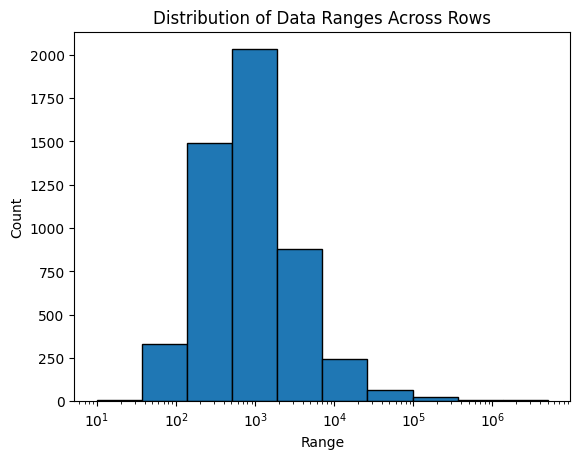

In [13]:
# Assume row_range is a Pandas Series containing the range of values for each row of your DataFrame
# Define the minimum and maximum range values to plot
range_min = 10
range_max = row_range.max()
# Define the number of logarithmically spaced bins to use
num_bins = 10
# Use numpy.logspace to create a sequence of range values that increases logarithmically
bin_edges = np.logspace(np.log10(range_min), np.log10(range_max), num=num_bins+1)
# Use numpy.histogram to count the number of values in each bin
hist, edges = np.histogram(row_range, bins=bin_edges)
# Plot the histogram
plt.title('Distribution of Data Ranges Across Rows')
plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', edgecolor='black')
plt.xscale('log')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

In [14]:
# compute the range of data across each row
row_max = train_data.apply(lambda row: row.max(), axis=1)
print(f'Row max min: {row_max.min()} \n Row max max: {row_max.max()} \n Row max average: {row_max.mean()}')
row_min = train_data.apply(lambda row: abs(row.min()), axis=1)
print(f'Row min min: {row_min.min()} \n Row min max: {row_min.max()} \n Row min average: {row_min.mean()}')

Row max min: 11.55 
 Row max max: 4299288.0 
 Row max average: 5290.579131118538
Row min min: 5.54 
 Row min max: 2385019.12 
 Row min average: 3400.7736799685476


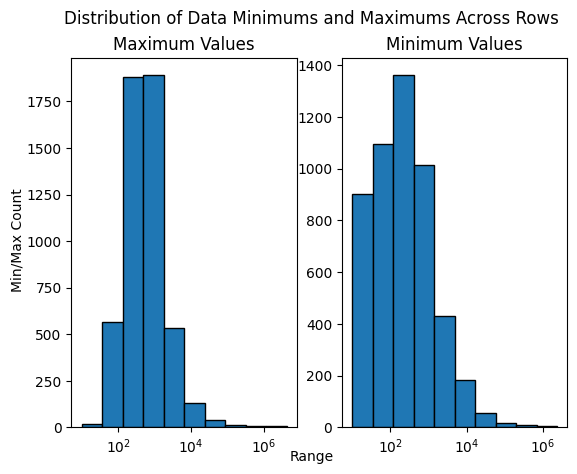

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Define the number of logarithmically spaced bins to use
num_bins = 10

# Use numpy.logspace to create a sequence of range values that increases logarithmically
max_bin_edges = np.logspace(np.log10(10), np.log10(row_max.max()), num=num_bins+1)
min_bin_edges = np.logspace(np.log10(10), np.log10(row_min.max()), num=num_bins+1)

# Use numpy.histogram to count the number of values in each bin
max_hist, max_edges = np.histogram(row_max, bins=max_bin_edges)
min_hist, min_edges = np.histogram(row_min, bins=min_bin_edges)

# Plot the histogram
plt.suptitle('Distribution of Data Minimums and Maximums Across Rows')
ax1.bar(max_edges[:-1], max_hist, width=np.diff(max_edges), align='edge', edgecolor='black')
ax2.bar(min_edges[:-1], min_hist, width=np.diff(min_edges), align='edge', edgecolor='black')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.title.set_text('Maximum Values')
ax2.title.set_text('Minimum Values')
fig.text(0.04, 0.5, 'Min/Max Count', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Range', ha='center')
plt.show()

In [16]:
range_result = (((row_range > 0) & (row_range < 10000)).sum()) / len(row_range) * 100
max_result = (((row_max > 0) & (row_max < 10000)).sum()) / len(row_max) * 100
min_result = (((row_min > 0) & (row_min < 10000)).sum()) / len(row_max) * 100
print(f"{range_result:.2f}% of row ranges are less than 10,000 \n {max_result:.2f}% of row maximums are less than 10,000 \n {min_result:.2f}% of row minimums are greater than -10,000")

94.91% of row ranges are less than 10,000 
 97.46% of row maximums are less than 10,000 
 97.50% of row minimums are greater than -10,000


From this, it is safe to say some of our data points have large outliers compared to the rest of our data. We may want to see which rows have these outliers and possibly drop them. 

Let's look at the rows with outlier min and max ranges first (max over 10,000 and min under -10,000).

In [17]:
RANGE_OUTLIERS = row_range > 10000
MAX_OUTLIERS = row_max > 10000
MIN_OUTLIERS = row_min > 10000
filtered_df = train_data[(RANGE_OUTLIERS & MAX_OUTLIERS & MIN_OUTLIERS)]
print(f'There are {len(filtered_df)} points of data that meet the outlier criteria.')
print(filtered_df['LABEL'].value_counts())
print('84 of these outliers are non exoplanet detections. 1 is an exoplanet detection.')

There are 85 points of data that meet the outlier criteria.
LABEL
0    84
1     1
Name: count, dtype: int64
84 of these outliers are non exoplanet detections. 1 is an exoplanet detection.


We can see that each of these data point has an extremely large range and large min and max outliers. There is also a good ratio of non-exoplanet to exoplanet data that seems to mimic the ratio of our actual data. Let's drop these columns, but first we should check these values on the testing dataset as well.

In [18]:
filtered_test_df = test_data[(RANGE_OUTLIERS & MAX_OUTLIERS & MIN_OUTLIERS)]
print(f'There are {len(filtered_test_df)} points of data that meet the outlier criteria.')
print(filtered_test_df['LABEL'].value_counts())
print('9 of these outliers are non exoplanet detections. There are no outliers that have exoplanet detections.')

There are 9 points of data that meet the outlier criteria.
LABEL
0    9
Name: count, dtype: int64
9 of these outliers are non exoplanet detections. There are no outliers that have exoplanet detections.


This looks good to drop as well, especially since we don't have to drop any exoplanet detections in our test dataset, which already has a very low number of exoplanet detections to test with. Let's go ahead and drop these outlier rows.

In [19]:
mask = (RANGE_OUTLIERS & MAX_OUTLIERS & MIN_OUTLIERS)
train_indices_to_drop = train_data[mask].index
test_indices_to_drop = test_data[mask].index
print(train_indices_to_drop)
print(test_indices_to_drop)
train_data.drop(train_indices_to_drop, inplace=True)
train_data.reset_index(drop=True, inplace=True)
test_data.drop(test_indices_to_drop, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Index([  26,  170,  171,  199,  277,  286,  378,  412,  497,  738,  739,  765,
        778,  790,  816,  834,  835,  907,  921,  954,  962,  974,  978, 1038,
       1041, 1176, 1229, 1272, 1427, 1442, 1444, 1668, 1786, 1814, 1865, 1869,
       1908, 1951, 1953, 2017, 2079, 2123, 2294, 2315, 2337, 2407, 2410, 2420,
       2452, 2632, 2717, 2739, 2758, 2804, 3195, 3247, 3278, 3320, 3329, 3340,
       3383, 3569, 3572, 3579, 3680, 3768, 3786, 3836, 3868, 3952, 3966, 4006,
       4045, 4133, 4136, 4186, 4201, 4202, 4321, 4468, 4493, 4590, 4742, 4930,
       5039],
      dtype='int64')
Index([26, 170, 171, 199, 277, 286, 378, 412, 497], dtype='int64')


In [20]:
print(train_data.isnull().values.any())
train_data

False


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4997,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
4998,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
4999,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5000,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [21]:
print(test_data.isnull().values.any())
test_data

False


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,1,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,1,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,1,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
557,0,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
558,0,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
559,0,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [22]:
row_max = train_data.apply(lambda row: row.max(), axis=1)
row_min = train_data.apply(lambda row: row.min(), axis=1)
print(f'Train data maximum: {row_max.max()}, minimum: {row_min.min()}')
print(f'Range: {row_max.max() - row_min.min()}')

Train data maximum: 125974.96, minimum: -141621.5
Range: 267596.46


This range shouldn't be too bad. Let's see how our data scales between -1 and 1 with this range.

To normalize our data, we'll be using sklearn's MinMaxScaler, which scales each number to a float value between 0 and 1. This will make it easier to relate each flux value to the next. And of course, we won't be scaling our classification data (LABEL) because that is the class we will be predicting for (and for consolation, it is already scaled to 0 and 1).

In [23]:
unscaled_train_col = train_data['LABEL']
unscaled_test_col = test_data['LABEL']

##### Using `MaxAbsScaler()`

In [24]:
ma_train_scaler = MaxAbsScaler()
ma_train_scaler.fit(train_data.drop(columns=['LABEL']))
ma_train_scaled = ma_train_scaler.fit_transform(train_data.drop(columns=['LABEL']))
ma_scaled_train_data = pd.DataFrame(ma_train_scaled, columns=train_data.drop(columns=['LABEL']).columns)
ma_scaled_train_data['LABEL'] = unscaled_train_col
print(ma_scaled_train_data.isnull().values.any())
print(ma_scaled_train_data['LABEL'].isna().sum())
print(ma_scaled_train_data['LABEL'].value_counts())
ma_scaled_train_data.head(5)

False
0
LABEL
0    4966
1      36
Name: count, dtype: int64


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,0.004680,0.003830,0.000797,-0.001020,-0.001559,-0.005633,-0.007859,-0.006705,-0.006007,-0.017388,...,-0.001940,-0.001798,0.000402,0.000750,0.001342,0.004173,0.006502,0.000443,-0.002441,1
1,-0.001939,-0.001546,-0.002321,-0.001515,-0.003125,-0.003289,-0.005032,-0.005943,-0.006314,-0.007966,...,-0.000612,-0.000567,-0.000399,-0.000075,0.000011,-0.001242,0.000684,0.001396,0.001230,1
2,0.026561,0.024491,0.020367,0.018779,0.017987,0.021048,0.027004,0.033876,0.032825,0.052584,...,0.000253,0.000234,-0.000479,-0.000323,0.000073,-0.001252,-0.003060,-0.006111,-0.005968,1
3,0.016283,0.015876,0.011987,0.011267,0.012521,0.014124,0.018739,0.021682,0.023491,0.035100,...,-0.000071,-0.000066,0.000481,0.000309,-0.000184,-0.000931,-0.001832,-0.001514,0.000863,1
4,-0.055213,-0.050845,-0.044361,-0.041385,-0.041673,-0.046726,-0.058040,-0.071229,-0.074407,-0.105397,...,-0.007629,-0.007069,-0.005721,-0.006856,-0.006360,-0.042418,-0.040720,-0.035939,-0.031519,1


In [25]:
ma_test_scaler = MaxAbsScaler()
ma_test_scaler.fit(test_data.drop(columns=['LABEL']))
ma_test_scaled = ma_test_scaler.fit_transform(test_data.drop(columns=['LABEL']))
ma_scaled_test_data = pd.DataFrame(ma_test_scaled, columns=test_data.drop(columns=['LABEL']).columns)

ma_scaled_test_data['LABEL'] = unscaled_test_col
print(ma_scaled_test_data.isnull().values.any())
print(ma_scaled_test_data['LABEL'].isna().sum())

print(ma_scaled_test_data['LABEL'].value_counts())
ma_scaled_test_data.head(5)

False
0
LABEL
0    556
1      5
Name: count, dtype: int64


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,0.000412,0.000345,0.000298,0.000168,0.000159,0.000136,0.000064,0.000024,0.000023,-0.000077,...,0.000097,0.000072,-0.000008,0.000065,0.000221,0.000157,0.000174,0.001302,0.000273,1
1,0.019721,0.019611,0.019677,0.019597,0.019511,0.019419,0.019455,0.019304,0.019312,0.019043,...,-0.004973,-0.006166,-0.007923,-0.008956,-0.010009,-0.011152,-0.011540,-0.011092,-0.009621,1
2,0.002903,0.002813,0.002650,0.002324,0.002086,0.001722,0.001524,0.001258,0.000721,0.000525,...,-0.000261,-0.000242,-0.000297,-0.000403,-0.000848,-0.000469,-0.000793,-0.000178,0.000145,1
3,-0.002840,-0.002846,-0.002912,-0.002878,-0.002568,-0.002706,-0.002736,-0.002587,-0.002469,-0.002371,...,0.000470,0.000466,0.000341,0.000048,0.000101,0.000100,-0.000589,-0.001245,-0.001019,1
4,-0.000136,-0.000055,-0.000032,-0.000022,-0.000056,-0.000083,-0.000003,-0.000157,-0.000018,0.000051,...,-0.000313,-0.000136,-0.000105,-0.000166,-0.000414,-0.000401,-0.000302,-0.000335,-0.000084,1


#### Using `MinMaxScaler()`

In [26]:
mm_train_scaler = MinMaxScaler()
mm_train_scaler.fit(train_data.drop(columns=['LABEL']))
mm_train_scaled = mm_train_scaler.fit_transform(train_data.drop(columns=['LABEL']))
mm_scaled_train_data = pd.DataFrame(mm_train_scaled, columns=train_data.drop(columns=['LABEL']).columns)

mm_scaled_train_data['LABEL'] = unscaled_train_col
print(mm_scaled_train_data.isnull().values.any())
print(mm_scaled_train_data['LABEL'].isna().sum())

print(mm_scaled_train_data['LABEL'].value_counts())
mm_scaled_train_data.head(5)

False
0
LABEL
0    4966
1      36
Name: count, dtype: int64


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,0.681665,0.700343,0.726991,0.726409,0.715536,0.692573,0.641611,0.601192,0.585646,0.481523,...,0.537263,0.522969,0.507592,0.503954,0.500766,0.500903,0.532495,0.546432,0.585463,1
1,0.677174,0.696592,0.724727,0.726049,0.714413,0.694206,0.643439,0.601653,0.585466,0.486324,...,0.537978,0.523614,0.507186,0.503538,0.500101,0.498189,0.529417,0.546953,0.587618,1
2,0.696511,0.714758,0.741207,0.740806,0.729543,0.711156,0.664157,0.625753,0.608526,0.517182,...,0.538443,0.524033,0.507145,0.503414,0.500132,0.498184,0.527436,0.542852,0.583393,1
3,0.689537,0.708747,0.735120,0.735343,0.725626,0.706334,0.658812,0.618373,0.603026,0.508272,...,0.538269,0.523876,0.507632,0.503732,0.500003,0.498345,0.528085,0.545363,0.587402,1
4,0.641028,0.662198,0.694188,0.697057,0.686788,0.663952,0.609159,0.562138,0.545346,0.436672,...,0.534201,0.520207,0.504485,0.500124,0.496914,0.477552,0.507512,0.526561,0.568398,1


In [27]:
mm_test_scaler = MinMaxScaler()
mm_test_scaler.fit(test_data.drop(columns=['LABEL']))
mm_test_scaled = mm_test_scaler.fit_transform(test_data.drop(columns=['LABEL']))
mm_scaled_test_data = pd.DataFrame(mm_test_scaled, columns=test_data.drop(columns=['LABEL']).columns)

mm_scaled_test_data['LABEL'] = unscaled_test_col
print(mm_scaled_test_data.isnull().values.any())
print(mm_scaled_test_data['LABEL'].isna().sum())

print(mm_scaled_test_data['LABEL'].value_counts())
mm_scaled_test_data.head(5)

False
0
LABEL
0    556
1      5
Name: count, dtype: int64


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,0.169969,0.048355,0.163241,0.036064,0.158311,0.026144,0.156365,0.021636,0.157775,0.104238,...,0.311329,0.310210,0.308639,0.306981,0.305682,0.299232,0.297804,0.297246,0.292792,1
1,0.186003,0.066696,0.179461,0.054796,0.174602,0.044926,0.172725,0.040499,0.174021,0.121363,...,0.307837,0.305907,0.303167,0.300729,0.298577,0.291306,0.289577,0.288524,0.285793,1
2,0.172038,0.050704,0.165210,0.038143,0.159934,0.027690,0.157597,0.022843,0.158363,0.104776,...,0.311083,0.309993,0.308439,0.306657,0.304940,0.298793,0.297124,0.296205,0.292701,1
3,0.167269,0.045317,0.160554,0.033128,0.156016,0.023376,0.154003,0.019081,0.155676,0.102183,...,0.311586,0.310481,0.308880,0.306969,0.305598,0.299192,0.297268,0.295454,0.291878,1
4,0.169514,0.047975,0.162965,0.035881,0.158131,0.025931,0.156309,0.021459,0.157741,0.104352,...,0.311047,0.310066,0.308572,0.306821,0.305241,0.298841,0.297469,0.296094,0.292539,1


It seems that MaxAbsScaler is able to capture the spread of data more accurately, whereas using MinMaxScaler does not allow for much range and gives us values that seem really close together, which may cause us to lose hueristics and will affect our machine learning later on. Let's plan on using the MaxAbsScaler values for now. Let's plot some of our scaled training exoplanet and non-exoplanet light curves to check that the overall scale is still kept across points of data.

In [28]:
r_scaler = RobustScaler()
r_scaler.fit(train_data.drop(columns=['LABEL']))
r_scaled = r_scaler.fit_transform(train_data.drop(columns=['LABEL']))
r_scaled_train_data = pd.DataFrame(r_scaled, columns=train_data.drop(columns=['LABEL']).columns)

r_scaled_train_data['LABEL'] = unscaled_train_col
print(r_scaled_train_data.isnull().values.any())
print(r_scaled_train_data['LABEL'].isna().sum())

print(r_scaled_train_data['LABEL'].value_counts())
print(r_scaled_train_data['LABEL'].isna().sum())
r_scaled_train_data.head(5)

False
0
LABEL
0    4966
1      36
Name: count, dtype: int64
0


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,1.086182,1.056810,0.269639,-0.368636,-0.561666,-1.884670,-2.254742,-1.677368,-1.425184,-2.928686,...,-2.610492,-2.491060,0.448608,0.932189,1.674066,0.934401,1.473805,0.106592,-1.056881,1
1,-0.439012,-0.412817,-0.748091,-0.550014,-1.135383,-1.093963,-1.438392,-1.485439,-1.498473,-1.332475,...,-0.869500,-0.834695,-0.592662,-0.166572,-0.052582,-0.258770,0.146910,0.385057,0.477235,1
2,6.128296,6.704832,6.658017,6.879566,6.597315,7.114911,7.812070,8.544737,7.851805,8.925836,...,0.263613,0.243339,-0.696747,-0.496016,0.028313,-0.261109,-0.707026,-1.808492,-2.530633,1
3,3.759782,4.349605,3.922415,4.129289,4.595295,4.779356,5.425466,5.473158,5.621879,5.963676,...,-0.160558,-0.160213,0.551028,0.345278,-0.305239,-0.190248,-0.426968,-0.465383,0.323746,1
4,-12.715139,-13.889316,-14.471528,-15.146168,-15.254456,-15.745191,-16.744586,-17.930702,-17.765763,-17.838981,...,-10.066090,-9.584251,-7.511215,-9.192329,-8.317092,-9.332905,-9.295630,-10.523779,-13.207017,1


In [29]:
r_scaler = RobustScaler()
r_scaler.fit(test_data.drop(columns=['LABEL']))
r_scaled = r_scaler.fit_transform(test_data.drop(columns=['LABEL']))
r_scaled_test_data = pd.DataFrame(r_scaled, columns=test_data.drop(columns=['LABEL']).columns)

r_scaled_test_data['LABEL'] = unscaled_test_col
print(r_scaled_test_data.isnull().values.any())
print(r_scaled_test_data['LABEL'].isna().sum())

print(r_scaled_test_data['LABEL'].value_counts())
r_scaled_test_data.head(5)

False
0
LABEL
0    556
1      5
Name: count, dtype: int64


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197,LABEL
0,0.987029,0.876087,0.766183,0.503801,0.523931,0.626175,0.368472,0.180576,0.197257,-0.390505,...,0.450853,0.231986,-0.130677,0.171282,0.694974,0.868390,1.059558,5.586319,1.457028,1
1,47.687869,50.052955,50.020031,57.716675,62.618658,84.072974,90.758865,92.842412,104.345482,119.512579,...,-29.077693,-30.082765,-37.174930,-40.870701,-37.531664,-54.118689,-61.410403,-46.618282,-48.221035,1
2,7.011807,7.175200,6.745976,6.852813,6.707196,7.491718,7.173759,6.110445,3.966560,3.381755,...,-1.637139,-1.295034,-1.483086,-1.959803,-3.297768,-2.174444,-4.101951,-0.647801,0.813865,1
3,-6.877609,-7.269342,-7.391445,-8.464369,-8.226152,-11.671691,-12.684236,-12.371148,-13.256810,-14.776635,...,2.620954,2.145083,1.501158,0.092675,0.245872,0.588897,-3.013004,-5.142305,-5.027540,1
4,-0.338738,-0.143409,-0.070241,-0.054232,-0.164143,-0.320549,0.054642,-0.688656,-0.021980,0.409976,...,-1.937022,-0.780428,-0.583874,-0.880304,-1.679187,-1.844939,-1.482965,-1.310464,-0.336895,1


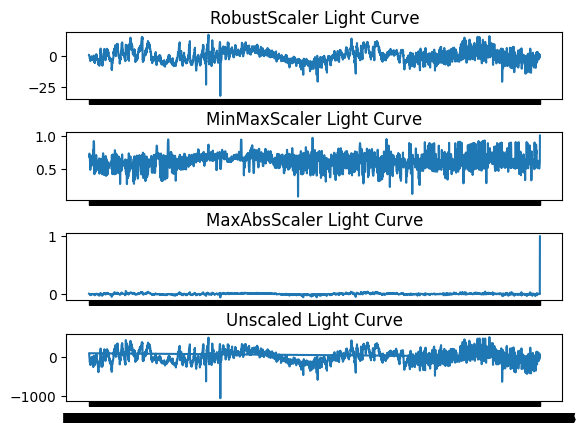

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
ax1.plot(r_scaled_train_data.iloc[0])
ax1.title.set_text('RobustScaler Light Curve')

ax2.plot(mm_scaled_train_data.iloc[0])
ax2.title.set_text('MinMaxScaler Light Curve')

ax3.plot(ma_scaled_train_data.iloc[0])
ax3.title.set_text('MaxAbsScaler Light Curve')

ax4.plot(train_data.iloc[0])
ax4.title.set_text('Unscaled Light Curve')

fig.subplots_adjust(hspace=0.5) # Adjust the spacing between subplots
plt.show()

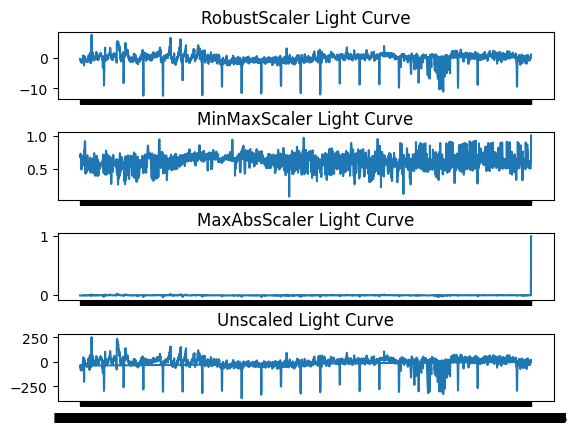

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
ax1.plot(r_scaled_train_data.iloc[1])
ax1.title.set_text('RobustScaler Light Curve')

ax2.plot(mm_scaled_train_data.iloc[1])
ax2.title.set_text('MinMaxScaler Light Curve')

ax3.plot(ma_scaled_train_data.iloc[1])
ax3.title.set_text('MaxAbsScaler Light Curve')

ax4.plot(train_data.iloc[1])
ax4.title.set_text('Unscaled Light Curve')

fig.subplots_adjust(hspace=0.5) # Adjust the spacing between subplots
plt.show()

We can see from this graph that MaxAbsScaler does not do a good job at all, MinMaxScaler does okay, but RobustScaler does a really good job. We will stick with RobustScaler for our normalization.

In [32]:
scaled_train_data = r_scaled_train_data
scaled_test_data = r_scaled_test_data

print(scaled_train_data['LABEL'].value_counts())
print(scaled_test_data['LABEL'].value_counts())

LABEL
0    4966
1      36
Name: count, dtype: int64
LABEL
0    556
1      5
Name: count, dtype: int64


In [33]:
SCALED_NON_EXOPLANET_TEST = (scaled_test_data['LABEL'] == 0)
SCALED_EXOPLANET_TEST = (scaled_test_data['LABEL'] == 1)
scaled_test_nonexoplanet = scaled_test_data[SCALED_NON_EXOPLANET_TEST]
scaled_test_exoplanet = scaled_test_data[SCALED_EXOPLANET_TEST]

SCALED_NON_EXOPLANET_TRAIN = (scaled_train_data['LABEL'] == 0)
SCALED_EXOPLANET_TRAIN = (scaled_train_data['LABEL'] == 1)
scaled_train_nonexoplanet = scaled_train_data[SCALED_NON_EXOPLANET_TRAIN]
scaled_train_exoplanet = scaled_train_data[SCALED_EXOPLANET_TRAIN]

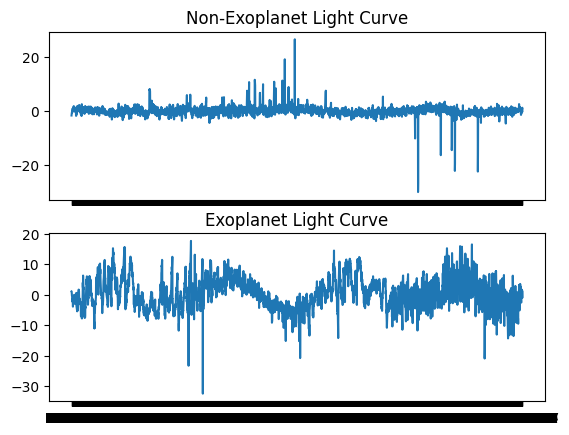

In [34]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(scaled_train_nonexoplanet.iloc[0])
ax1.title.set_text('Non-Exoplanet Light Curve')
ax2.plot(scaled_train_exoplanet.iloc[0])
ax2.title.set_text('Exoplanet Light Curve')

Now that these are scaled let's plot a few over eachother to see if we can see any patterns in nonexoplanet vs. exoplanet detection light curves.

Text(0, 0.5, 'Flux')

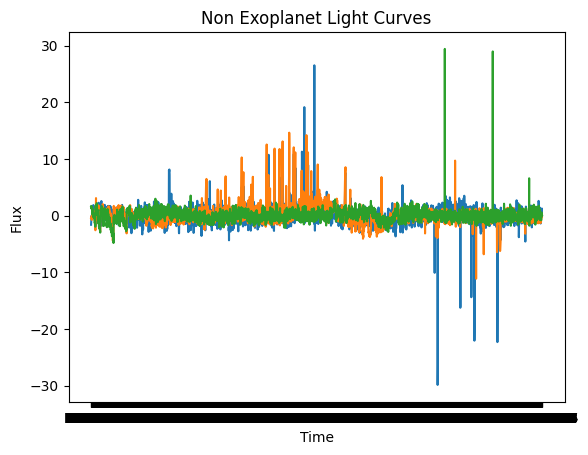

In [35]:
plt.plot(scaled_train_nonexoplanet.iloc[0])
plt.plot(scaled_train_nonexoplanet.iloc[1])
plt.plot(scaled_train_nonexoplanet.iloc[2])
plt.title('Non Exoplanet Light Curves')
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

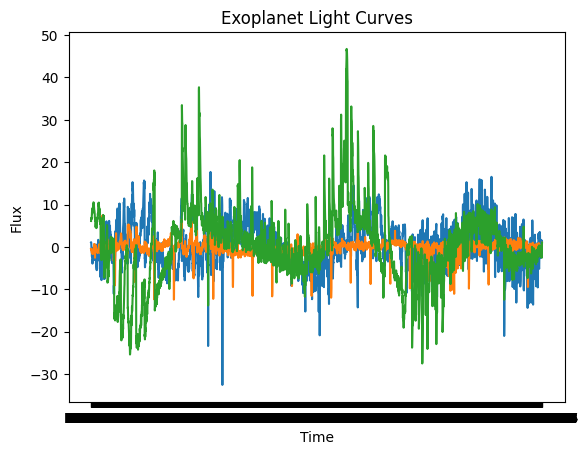

In [36]:
plt.plot(scaled_train_exoplanet.iloc[0])
plt.plot(scaled_train_exoplanet.iloc[1])
plt.plot(scaled_train_exoplanet.iloc[2])
plt.title('Exoplanet Light Curves')
plt.xlabel('Time')
plt.ylabel('Flux')

It seems that there is more variance in exoplanet detected light curves. Hopefully this will make it easier for our models to detect patterns. Now that our data is cleaned, processed, and scaled, let's move onto the actual machine learning!

### Machine Learning

First, we want to try to do some dimensionality reduction on our dataset to reduce those 3,000+ (yikes) columns. We can use Linear Discriminant Analysis to do this. However, keep in mind that after we apply LDA, we lose readability of our data (aka the data will no longer make sense when reading it from a table). 

In [37]:
X_train = scaled_train_data.drop(columns=['LABEL'])
y_train = scaled_train_data['LABEL']
X_test = scaled_test_data.drop(columns=['LABEL'])
y_test = scaled_test_data['LABEL']

print(X_train, y_train)
print(X_test, y_test)

         FLUX.1     FLUX.2     FLUX.3     FLUX.4     FLUX.5     FLUX.6   
0      1.086182   1.056810   0.269639  -0.368636  -0.561666  -1.884670  \
1     -0.439012  -0.412817  -0.748091  -0.550014  -1.135383  -1.093963   
2      6.128296   6.704832   6.658017   6.879566   6.597315   7.114911   
3      3.759782   4.349605   3.922415   4.129289   4.595295   4.779356   
4    -12.715139 -13.889316 -14.471528 -15.146168 -15.254456 -15.745191   
...         ...        ...        ...        ...        ...        ...   
4997  -1.048377  -1.151629  -1.009771  -1.341934  -0.972144  -1.024338   
4998  11.380925  11.140823  11.767374  11.789776  10.907917   9.396839   
4999   3.149267   3.482745   3.396726   3.283412   4.061124   4.051114   
5000   0.051652   0.035916  -0.033066  -0.035210   0.033268   0.003885   
5001   3.722551   3.837034   3.803481   3.984574   3.616006   3.341154   

         FLUX.7     FLUX.8     FLUX.9    FLUX.10  ...  FLUX.3188  FLUX.3189   
0     -2.254742  -1.677368  -1.4

In [38]:
lda = LinearDiscriminantAnalysis()
X_train_reduced_lda = lda.fit_transform(X_train, y_train)
X_test_reduced_lda = lda.transform(X_test)

Now let's run our selected models with the LDA X_train data.

In [39]:
models = {
    "SVC": {
        "Estimator": SVC(),
    },
    "KNN": {
        "Estimator": KNeighborsClassifier(),
        },
    "CART": {
        "Estimator": DecisionTreeClassifier(),
        },
    "FOREST": {
        "Estimator": RandomForestClassifier(),
    }
}

for name in models:
    models[name]["All_Scores"] = list()
    models[name]["Top_Score"] = float()
    models[name]["Mean_Score"] = float()
    models[name]["Std_Score"] = float()

In [42]:
NUM_FOLDS, ACC_SCORING = 10, "accuracy"

for name in models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    accuracy_results = cross_val_score(estimator=models[name]["Estimator"], 
                                       X=X_train_reduced_lda, 
                                       y=y_train, 
                                       cv=folds, 
                                       scoring=ACC_SCORING)
    models[name]["Top_Score"] = accuracy_results.max()
    models[name]["Mean_Score"] = accuracy_results.mean()
    models[name]["Std_Score"] = accuracy_results.std()
    for result in accuracy_results:
        models[name]["All_Scores"].append(result)

In [45]:
for name in models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance: \t\t{:.4f}".format(models[name]["Top_Score"]))
    print(">>>> Average Performance: \t{:.4f}".format(models[name]["Mean_Score"]))
    print(">>>> Spread of Performance: \t{:.4f}".format(models[name]["Std_Score"]))


[MODEL TYPE: SVC]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	1.0000
>>>> Spread of Performance: 	0.0000

[MODEL TYPE: KNN]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	1.0000
>>>> Spread of Performance: 	0.0000

[MODEL TYPE: CART]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	1.0000
>>>> Spread of Performance: 	0.0000

[MODEL TYPE: FOREST]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	1.0000
>>>> Spread of Performance: 	0.0000


This is a bit concerning when we get 100% accuracy scores. This is definitely overfitting the data and finding patterns that are not there. We can also use PCA, but we will have to use our MinMaxScaler data for this because PCA requires data to be scaled between 0 and 1. We will initialize our PCA object to keep 95% of the data's variance.

In [46]:
X_train_mm_scaled = mm_scaled_train_data.drop(columns=['LABEL'])
y_train_mm_scaled = mm_scaled_train_data['LABEL']
X_test_mm_scaled = mm_scaled_test_data.drop(columns=['LABEL'])
y_test_mm_scaled = mm_scaled_test_data['LABEL']

In [47]:
pca = PCA(n_components = 0.95)
X_train_reduced_pca = pca.fit_transform(X_train_mm_scaled, y_train_mm_scaled)
X_test_reduced_pca = pca.transform(X_test_mm_scaled)

In [48]:
NUM_FOLDS, SCORING = 10, "accuracy"

for name in models:
    models[name]["All_Scores"] = list()
    models[name]["Top_Score"] = float()
    models[name]["Mean_Score"] = float()
    models[name]["Std_Score"] = float()

for name in models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    results = cross_val_score(estimator=models[name]["Estimator"], 
                              X=X_train_reduced_pca, 
                              y=y_train_mm_scaled, 
                              cv=folds, 
                              scoring=SCORING)
    models[name]["Top_Score"] = results.max()
    models[name]["Mean_Score"] = results.mean()
    models[name]["Std_Score"] = results.std()
    for result in results:
        models[name]["All_Scores"].append(result)

for name in models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance (Acc): \t\t{:.4f}".format(models[name]["Top_Score"]))
    print(">>>> Average Performance (Acc): \t{:.4f}".format(models[name]["Mean_Score"]))
    print(">>>> Spread of Performance (Acc): \t{:.4f}".format(models[name]["Std_Score"]))


[MODEL TYPE: SVC]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010

[MODEL TYPE: KNN]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010

[MODEL TYPE: CART]

>>>> Top Performance (Acc): 		0.9900
>>>> Average Performance (Acc): 	0.9814
>>>> Spread of Performance (Acc): 	0.0048

[MODEL TYPE: FOREST]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010


In [49]:
pd.DataFrame(pca.components_.T, index=X_train_mm_scaled.columns)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
FLUX.1,0.004371,0.010093,0.000771,-0.022927,-0.003463,-0.023025,-0.001663,-0.021660,0.024450,-0.053190,...,-0.013851,-0.047333,0.011447,-0.032373,-0.006506,-0.002424,0.026445,0.006482,0.026149,-0.027490
FLUX.2,0.004716,0.009437,-0.000256,-0.033669,0.000045,-0.021973,-0.002459,-0.013835,0.015928,-0.050622,...,-0.014965,-0.049317,0.009914,-0.023063,-0.010160,-0.008053,0.010624,0.007575,0.018391,-0.015894
FLUX.3,0.005594,0.007420,0.006889,-0.018056,-0.001076,-0.021751,-0.003579,-0.010001,0.008214,-0.046860,...,-0.018212,-0.052308,0.005604,-0.010128,-0.012385,-0.010379,-0.017185,0.004482,0.002699,-0.019712
FLUX.4,0.005647,0.006414,0.010146,-0.005145,-0.005671,-0.021869,-0.003536,-0.010837,0.005367,-0.046035,...,-0.027630,-0.049974,-0.004645,-0.022761,-0.008940,0.002926,-0.011165,0.013461,0.001172,-0.018008
FLUX.5,0.005743,0.006900,0.009937,0.001871,-0.013780,-0.022991,-0.003230,-0.010971,0.003561,-0.046652,...,-0.030338,-0.039831,-0.007730,-0.032925,-0.008341,0.012118,0.000719,0.020407,0.007419,-0.011669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FLUX.3193,0.016099,0.008508,-0.018074,0.006031,0.010166,0.005397,0.003315,0.002591,0.006617,0.007975,...,-0.011967,0.003985,-0.006943,-0.002078,0.004398,0.003688,-0.007545,-0.004073,0.011843,0.013353
FLUX.3194,0.017382,0.000094,-0.006055,0.019362,0.023972,0.014333,0.007695,0.013199,-0.007110,0.006968,...,-0.025704,-0.011477,-0.001241,0.013632,0.006587,0.006312,-0.077102,-0.004157,0.019260,0.000292
FLUX.3195,0.023950,0.002540,-0.009114,0.031737,0.028285,0.016338,0.008356,0.014072,-0.005600,0.010757,...,-0.028060,-0.002650,-0.002517,0.024889,0.011103,0.013793,-0.069954,-0.011916,0.036298,-0.012828
FLUX.3196,0.022355,0.005292,-0.015498,0.023738,0.019382,0.014373,0.008340,0.014208,-0.005824,0.012890,...,-0.022464,-0.001476,0.000966,0.025784,0.019805,0.019728,-0.030064,-0.002072,0.036269,-0.012388


As we can see, PCA reduced our data down to 87 columns, a great change from our 3,000+ columns. And, we don't have perfect scoring anymore meaning it is not overfitting as much, although the results are still very high, >98% accuracy for each model. Let's try to run the models without any dimensionality reduction to see how it compares to the options above.

In [50]:
NUM_FOLDS, SCORING = 10, "accuracy"

for name in models:
    models[name]["All_Scores"] = list()
    models[name]["Top_Score"] = float()
    models[name]["Mean_Score"] = float()
    models[name]["Std_Score"] = float()

for name in models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    results = cross_val_score(estimator=models[name]["Estimator"], 
                              X=X_train, 
                              y=y_train, 
                              cv=folds, 
                              scoring=SCORING)
    models[name]["Top_Score"] = results.max()
    models[name]["Mean_Score"] = results.mean()
    models[name]["Std_Score"] = results.std()
    for result in results:
        models[name]["All_Scores"].append(result)

for name in models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance (Acc): \t\t{:.4f}".format(models[name]["Top_Score"]))
    print(">>>> Average Performance (Acc): \t{:.4f}".format(models[name]["Mean_Score"]))
    print(">>>> Spread of Performance (Acc): \t{:.4f}".format(models[name]["Std_Score"]))


[MODEL TYPE: SVC]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010

[MODEL TYPE: KNN]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010

[MODEL TYPE: CART]

>>>> Top Performance (Acc): 		0.9900
>>>> Average Performance (Acc): 	0.9778
>>>> Spread of Performance (Acc): 	0.0067

[MODEL TYPE: FOREST]

>>>> Top Performance (Acc): 		0.9940
>>>> Average Performance (Acc): 	0.9928
>>>> Spread of Performance (Acc): 	0.0010


Our accuracy scores are overall lower than LDA by about 1-2% which is better, but it took an extremely long time due to our insane amount of data. The accuracy scores are still very high which still means our models are overfitting.

In [51]:
# Trying with lowest accuracy which is most likely doing the least overfitting
CART_model_normal = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = CART_model_normal.predict(X_test)
print('Decision Tree Classifier With no Dimensionality Reduction')
print(accuracy_score(y_true=y_test, y_pred=y_pred))

CART_model_lda = DecisionTreeClassifier().fit(X_train_reduced_lda, y_train)
y_pred = CART_model_lda.predict(X_test_reduced_lda)
print('Decision Tree Classifier With LDA Dimensionality Reduction')
print(accuracy_score(y_true=y_test, y_pred=y_pred))

CART_model_pca = DecisionTreeClassifier().fit(X_train_reduced_pca, y_train_mm_scaled)
y_pred = CART_model_pca.predict(X_test_reduced_pca)
print('Decision Tree Classifier With PCA Dimensionality Reduction')
print(accuracy_score(y_true=y_test_mm_scaled, y_pred=y_pred))

Decision Tree Classifier With no Dimensionality Reduction
0.9732620320855615
Decision Tree Classifier With LDA Dimensionality Reduction
0.9340463458110517
Decision Tree Classifier With PCA Dimensionality Reduction
0.9910873440285205


From this analysis we can see that due to our large amounts of data and discrete patterns, we need something more powerful to predict with. Deep learning neural networks can be a great tool to process the large amount of data we have and find patterns without overfitting. Let's dive into some deep learning with neural networks!

### Applying Deep Learning Models

We'll pull our training and testing data down again just for better readability.

In [52]:
# reinstantiating train and test data for readability
X_train = scaled_train_data.drop(columns=['LABEL'])
y_train = scaled_train_data['LABEL']
X_test = scaled_test_data.drop(columns=['LABEL'])
y_test = scaled_test_data['LABEL']

Then we'll instantiate the layers we will use. Because we are building ANNs, we won't be using a lot of other layers which are usually used for image processing. We''l only need a dense layer, which is a layer of multiple perceptrons, and a dropout layer that will drop a set percentage of data and therefore will help with overfitting.

In [53]:
# instantiating layers for easier future reference
dense_layer = keras.layers.Dense
dropout_layer = keras.layers.Dropout

Now we'll instantiate some function for future visualization plotting. The first one is for plotting accuracy and loss metrics as a line function. The second is for plotting a confusion matrix.

In [54]:
def plot_training_results(history):
    """
    Visualize results of the model training using `matplotlib`.

    The visualization will include charts for accuracy and loss, 
    on the training and as well as validation data sets.

    INPUTS:
        history(tf.keras.callbacks.History): 
            Contains data on how the model metrics changed 
            over the course of training.
    
    OUTPUTS: 
        None.
    """
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [55]:
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrix. """
  axis = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", ax=axis)
  axis.set_title("Confusion Matrix")
  axis.set_xlabel("Predicted Labels")
  axis.set_ylabel("True Labels")
  if labels:
      axis.xaxis.set_ticklabels(labels)
      axis.yaxis.set_ticklabels(labels)
  plt.show()

Let's try a simple three-layer model to see how our baseline does. We will use one input layer with 1000 units and the relu activation function. Then a dense hidden layer with 500 units and the relu activation function. Then an output layer with 1 unit and the sigmoid activation function. We will use binary cross entropy for our loss function and the adam optimizer and track accuracy scores.

In [56]:
print(X_train.shape)

(5002, 3197)


In [57]:
model = Sequential()

input_layer = dense_layer(units=1000, 
                          activation='relu',
                          input_shape=(3197,))
hidden_layer = dense_layer(units=500,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(hidden_layer)
model.add(output_layer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              3198000   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 3,699,001
Trainable params: 3,699,001
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Compile Model (Put It Together)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [59]:
epochs = 10
history_v1 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
5002/5002 [==============================] - 32s 6ms/step - loss: 5.5772 - accuracy: 0.9806 - val_loss: 7.9115 - val_accuracy: 0.9911
Epoch 2/10
5002/5002 [==============================] - 30s 6ms/step - loss: 9.0499 - accuracy: 0.9822 - val_loss: 49.0919 - val_accuracy: 0.9893
Epoch 3/10
5002/5002 [==============================] - 31s 6ms/step - loss: 24.6946 - accuracy: 0.9768 - val_loss: 62.0499 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 31s 6ms/step - loss: 22.1102 - accuracy: 0.9884 - val_loss: 24.3933 - val_accuracy: 0.9875
Epoch 5/10
5002/5002 [==============================] - 33s 7ms/step - loss: 18.3447 - accuracy: 0.9866 - val_loss: 13.7332 - val_accuracy: 0.9857
Epoch 6/10
5002/5002 [==============================] - 32s 6ms/step - loss: 21.6697 - accuracy: 0.9902 - val_loss: 49.9891 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 33s 7ms/step - loss: 27.7278 - accuracy: 0.9880 - val_loss: 64.61

In [60]:
# Evaluate Model Using Training/Testing Data
_, training_accuracy = model.evaluate(X_train, y_train, verbose=0)
_, testing_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Display Evaluation Metrics (Accuracies)
print("Training Accuracy: {:.4f}\nTesting Accuracy: {:.4f}".format(training_accuracy,
                                                                   testing_accuracy))

Training Accuracy: 0.9978
Testing Accuracy: 0.9893


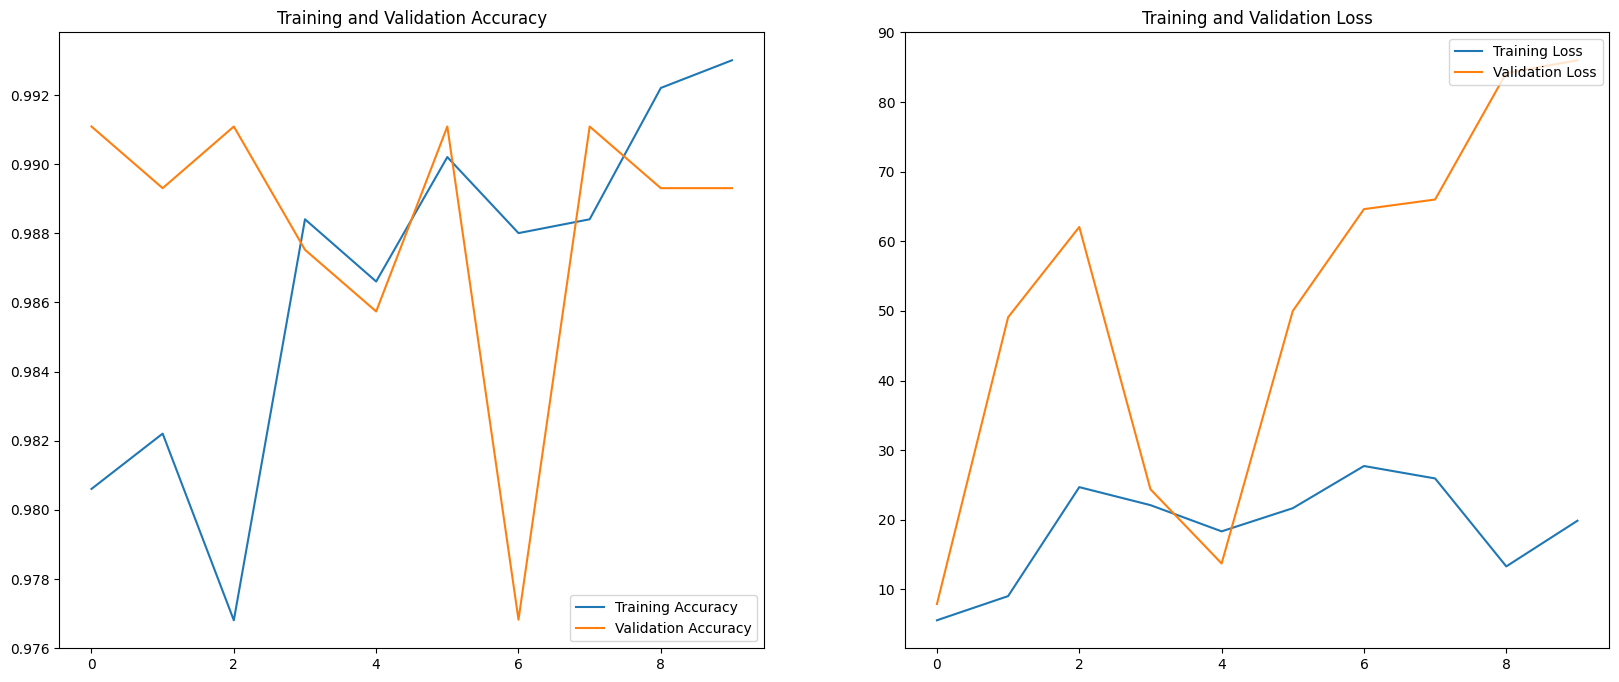

In [61]:
plot_training_results(history_v1)

18/18 [==============================] - 0s 6ms/step


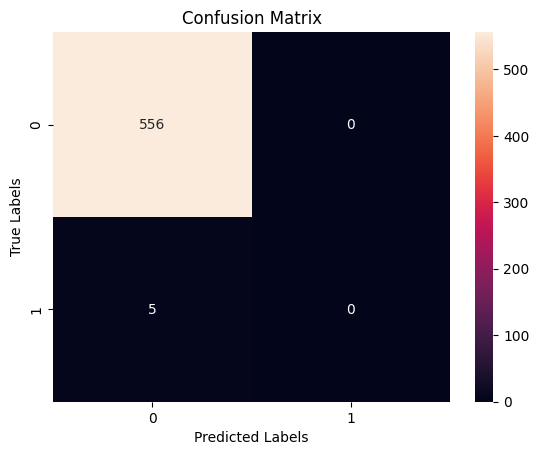

In [62]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Ideally, our accuracy curves would shoot up in the first few epochs, then level out, and our loss curves would shoot down in the first few epochs, then level out. As we can see, training accuracy and loss are very consistent. They start high and stay high. However, the validation scores are less than ideal, and they both take a hit on the 7th (shown as 8th on the graph) epoch. This can be a sign of overfitting. The model is learning patterns that aren't there, so it thinks it is doing well until it predicts patterns that are not true, causing the huge spike we see on the graph.

We knew that overfitting was an issue we need to tackle, and using a more robust model in itself will not do the trick of preventing overfitting from happening. Let's tweak it a bit more to try to prevent overfitting. We will add dropout layers and some regularization techniques. 

In [63]:
model = Sequential()

input_layer = dense_layer(units=1000, 
                          activation='relu',
                          input_shape=(3197,),
                          kernel_regularizer=l1(0.001))
dense_layer_1 = dense_layer(units=500,
                           activation='relu')
dropout_1 = dropout_layer(0.5)
dense_layer_2 = dense_layer(units=250,
                           activation='relu')
dropout_2 = dropout_layer(0.5)
dense_layer_3 = dense_layer(units=50,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(dense_layer_3)
model.add(output_layer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000)              3198000   
                                                                 
 dense_4 (Dense)             (None, 500)               500500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                12550     
                                                                 
 dense_7 (Dense)             (None, 1)                

In [64]:
# Compile Model (Put It Together)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [65]:
epochs = 10
history_v2 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
5002/5002 [==============================] - 38s 7ms/step - loss: 67.3374 - accuracy: 0.9842 - val_loss: 46.8765 - val_accuracy: 0.9911
Epoch 2/10
5002/5002 [==============================] - 37s 7ms/step - loss: 31.9883 - accuracy: 0.9862 - val_loss: 28.8905 - val_accuracy: 0.9911
Epoch 3/10
5002/5002 [==============================] - 38s 8ms/step - loss: 23.7563 - accuracy: 0.9864 - val_loss: 23.2480 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 37s 7ms/step - loss: 19.8148 - accuracy: 0.9846 - val_loss: 12.9536 - val_accuracy: 0.9911
Epoch 5/10
5002/5002 [==============================] - 38s 8ms/step - loss: 16.0364 - accuracy: 0.9896 - val_loss: 10.5808 - val_accuracy: 0.9911
Epoch 6/10
5002/5002 [==============================] - 37s 7ms/step - loss: 11.2523 - accuracy: 0.9884 - val_loss: 16.4162 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 37s 7ms/step - loss: 12.7671 - accuracy: 0.9892 - val_loss: 6.

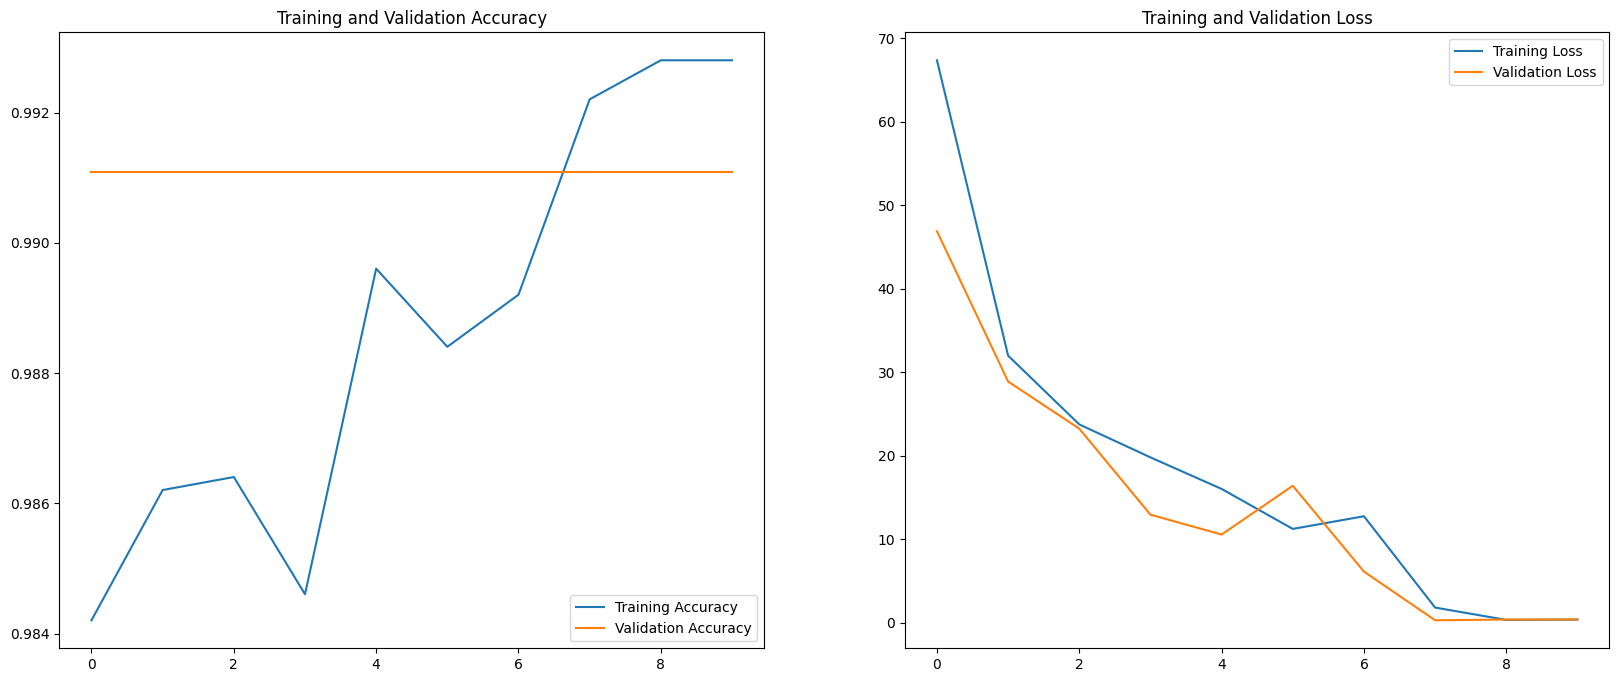

In [66]:
plot_training_results(history_v2)

18/18 [==============================] - 0s 7ms/step


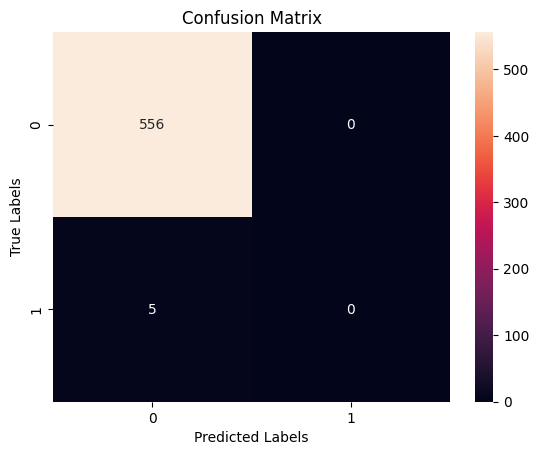

In [67]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Our loss function is sort of looking better. However, it is very strange that our validation accuracy does not change at all and our training accuracy does not look good at all. Let's try some more tuning. This time, we'll use the PCA reduction data (mostly so it will run faster) and we'll test with L2 regularization.

In [68]:
# 86 columns for X train and test data
# remember to use y minmaxscaled for validation
X_train_reduced_pca

array([[ 2.27539999e-02, -4.70550251e-03, -2.47848392e-02, ...,
         6.82000454e-03, -2.50280092e-02, -1.23418717e-02],
       [ 1.10164551e-02, -4.59483798e-03,  7.73511838e-03, ...,
         2.20475790e-03, -8.82818570e-03,  1.99246520e-04],
       [-1.34787967e-01, -2.03572862e-01, -1.51174091e-01, ...,
         3.86378672e-02, -1.47468198e-02, -2.31559825e-02],
       ...,
       [-2.86616242e-03, -1.70771431e-02, -1.95761801e-02, ...,
        -9.51730597e-03,  8.06180096e-03,  1.87733511e-03],
       [-9.53528338e-03, -1.36309966e-02, -1.52128375e-02, ...,
        -4.53608186e-04, -1.02741150e-03, -7.09315843e-04],
       [-3.90735481e-03, -2.15096564e-02, -1.60715830e-02, ...,
         9.20184520e-04,  2.59440336e-03, -2.13079120e-03]])

In [69]:
model = Sequential()

input_layer = dense_layer(units=1000, 
                          activation='relu',
                          input_shape=(87,),
                          kernel_regularizer=l2(0.001))
dense_layer_1 = dense_layer(units=500,
                           activation='relu')
dropout_1 = dropout_layer(0.5)
dense_layer_2 = dense_layer(units=250,
                           activation='relu')
dropout_2 = dropout_layer(0.5)
dense_layer_3 = dense_layer(units=50,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(dense_layer_3)
model.add(output_layer)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              88000     
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 250)               125250    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_11 (Dense)            (None, 50)                12550     
                                                                 
 dense_12 (Dense)            (None, 1)                

In [70]:
# Compile Model (Put It Together)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [71]:
epochs = 10
history_v3 = model.fit(
    X_train_reduced_pca,
    y_train_mm_scaled,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test_reduced_pca, y_test_mm_scaled)
)

Epoch 1/10
5002/5002 [==============================] - 13s 2ms/step - loss: 0.1178 - accuracy: 0.9926 - val_loss: 2.9227 - val_accuracy: 0.9911
Epoch 2/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0764 - accuracy: 0.9928 - val_loss: 0.2096 - val_accuracy: 0.9911
Epoch 3/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0684 - accuracy: 0.9926 - val_loss: 0.2679 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0534 - accuracy: 0.9928 - val_loss: 0.2309 - val_accuracy: 0.9911
Epoch 5/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0572 - accuracy: 0.9928 - val_loss: 0.0551 - val_accuracy: 0.9911
Epoch 6/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0669 - accuracy: 0.9928 - val_loss: 0.5817 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 12s 2ms/step - loss: 0.0571 - accuracy: 0.9928 - val_loss: 0.3537 - val_ac

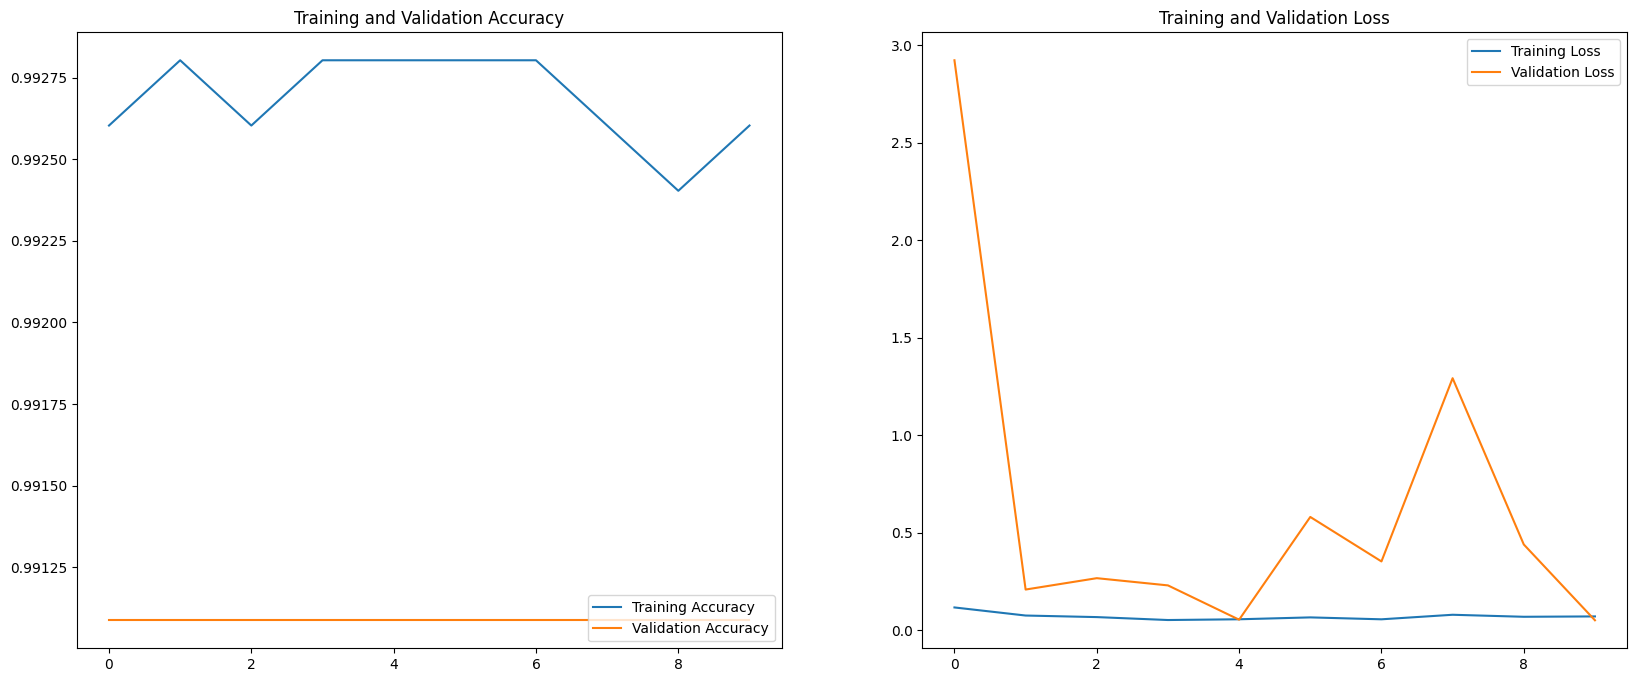

In [72]:
plot_training_results(history_v3)

18/18 [==============================] - 0s 2ms/step


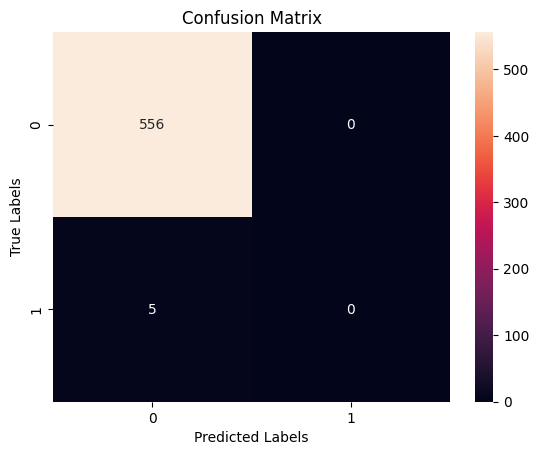

In [73]:
y_pred = np.argmax(model.predict(X_test_reduced_pca), axis=1)

cmat_(confusion_matrix(y_true=y_test_mm_scaled, 
                       y_pred=y_pred))

That does not look good. We may have made it too powerful. Let's try again.

In [74]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(87,))
dense_layer_1 = dense_layer(units=64, 
                          activation='relu',
                          kernel_regularizer=l2(0.001))
dropout_1 = dropout_layer(0.5)
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.25)
dense_layer_3 = dense_layer(units=4,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(dense_layer_3)
model.add(output_layer)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                5632      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 4)                 68        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 6,745
Trainable params: 6,745
Non-traina

In [75]:
# Compile Model (Put It Together)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [76]:
epochs = 10
history_v4 = model.fit(
    X_train_reduced_pca,
    y_train_mm_scaled,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test_reduced_pca, y_test_mm_scaled)
)

Epoch 1/10
5002/5002 [==============================] - 5s 836us/step - loss: 0.0722 - accuracy: 0.9928 - val_loss: 0.0971 - val_accuracy: 0.9911
Epoch 2/10
5002/5002 [==============================] - 4s 756us/step - loss: 0.0516 - accuracy: 0.9928 - val_loss: 0.0645 - val_accuracy: 0.9911
Epoch 3/10
5002/5002 [==============================] - 4s 759us/step - loss: 0.0465 - accuracy: 0.9928 - val_loss: 0.0542 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 4s 752us/step - loss: 0.0528 - accuracy: 0.9928 - val_loss: 0.0533 - val_accuracy: 0.9911
Epoch 5/10
5002/5002 [==============================] - 4s 752us/step - loss: 0.0510 - accuracy: 0.9928 - val_loss: 0.1054 - val_accuracy: 0.9911
Epoch 6/10
5002/5002 [==============================] - 4s 749us/step - loss: 0.0505 - accuracy: 0.9928 - val_loss: 0.0604 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 4s 747us/step - loss: 0.0476 - accuracy: 0.9928 - val_loss: 0.0525 -

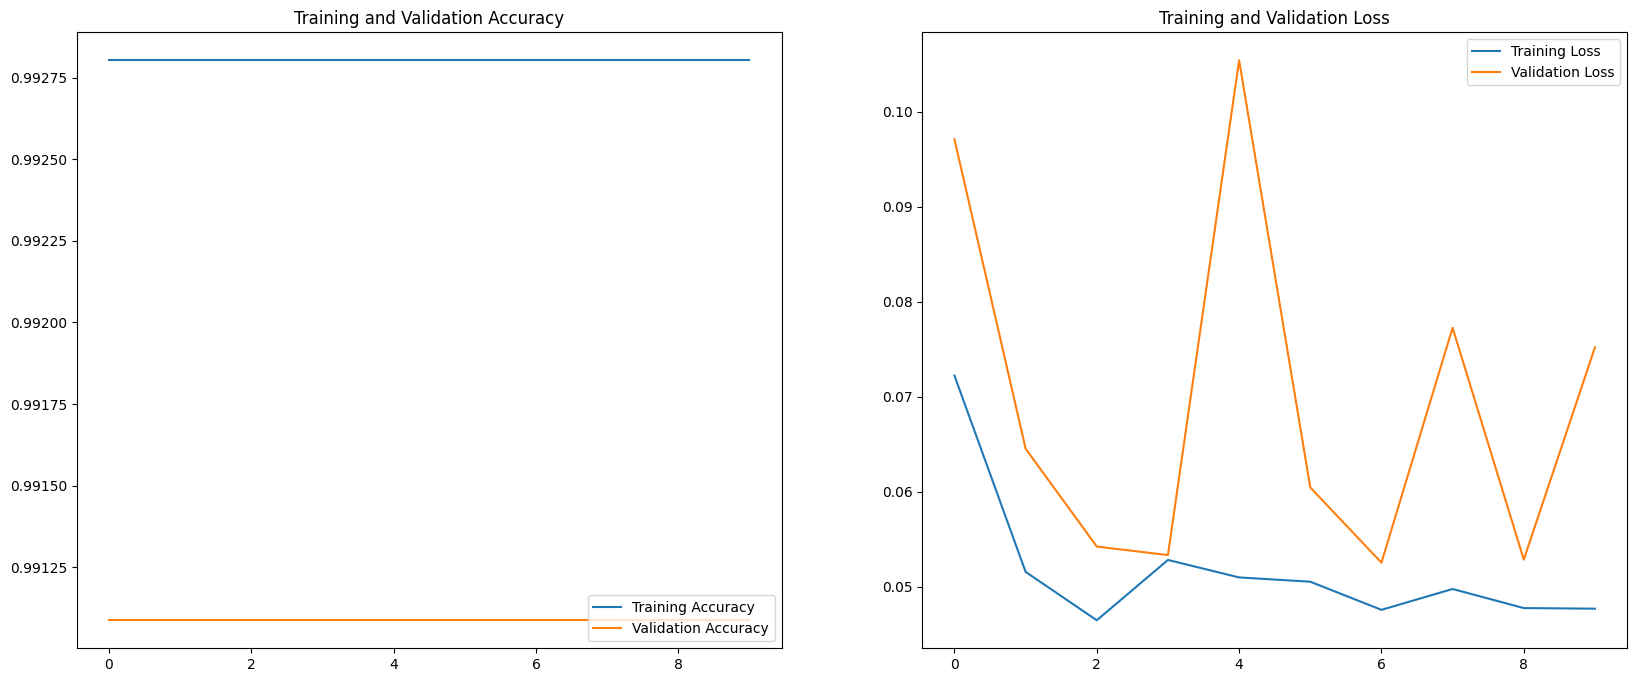

In [77]:
plot_training_results(history_v4)

18/18 [==============================] - 0s 624us/step


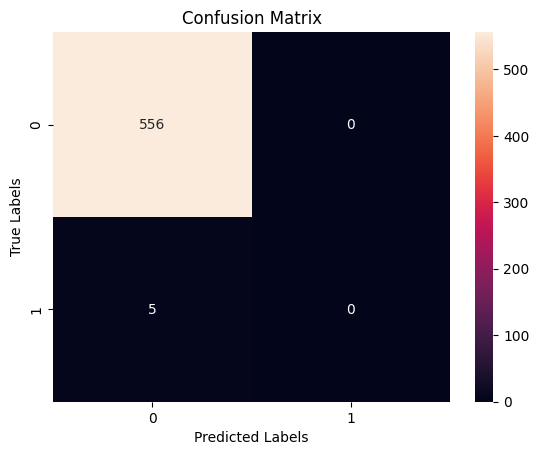

In [78]:
y_pred = np.argmax(model.predict(X_test_reduced_pca), axis=1)

cmat_(confusion_matrix(y_true=y_test_mm_scaled, 
                       y_pred=y_pred))

In [79]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(87,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=64, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.25)
# dense_layer_3 = dense_layer(units=4,
#                            activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(output_layer)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                5632      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Compile Model (Put It Together)
# optimizer = keras.optimizers.Adam(lr=10e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
optimizer = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [81]:
epochs = 10
history_v5 = model.fit(
    X_train_reduced_pca,
    y_train_mm_scaled,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test_reduced_pca, y_test_mm_scaled)
)

Epoch 1/10
5002/5002 [==============================] - 4s 681us/step - loss: 0.7589 - accuracy: 0.9918 - val_loss: 0.6041 - val_accuracy: 0.9911
Epoch 2/10
5002/5002 [==============================] - 3s 684us/step - loss: 0.5808 - accuracy: 0.9928 - val_loss: 0.5920 - val_accuracy: 0.9911
Epoch 3/10
5002/5002 [==============================] - 3s 658us/step - loss: 0.5449 - accuracy: 0.9928 - val_loss: 0.5706 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 3s 661us/step - loss: 0.5174 - accuracy: 0.9928 - val_loss: 0.5443 - val_accuracy: 0.9911
Epoch 5/10
5002/5002 [==============================] - 3s 672us/step - loss: 0.4908 - accuracy: 0.9928 - val_loss: 0.5181 - val_accuracy: 0.9911
Epoch 6/10
5002/5002 [==============================] - 3s 653us/step - loss: 0.4624 - accuracy: 0.9928 - val_loss: 0.4921 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 3s 677us/step - loss: 0.4412 - accuracy: 0.9928 - val_loss: 0.4654 -

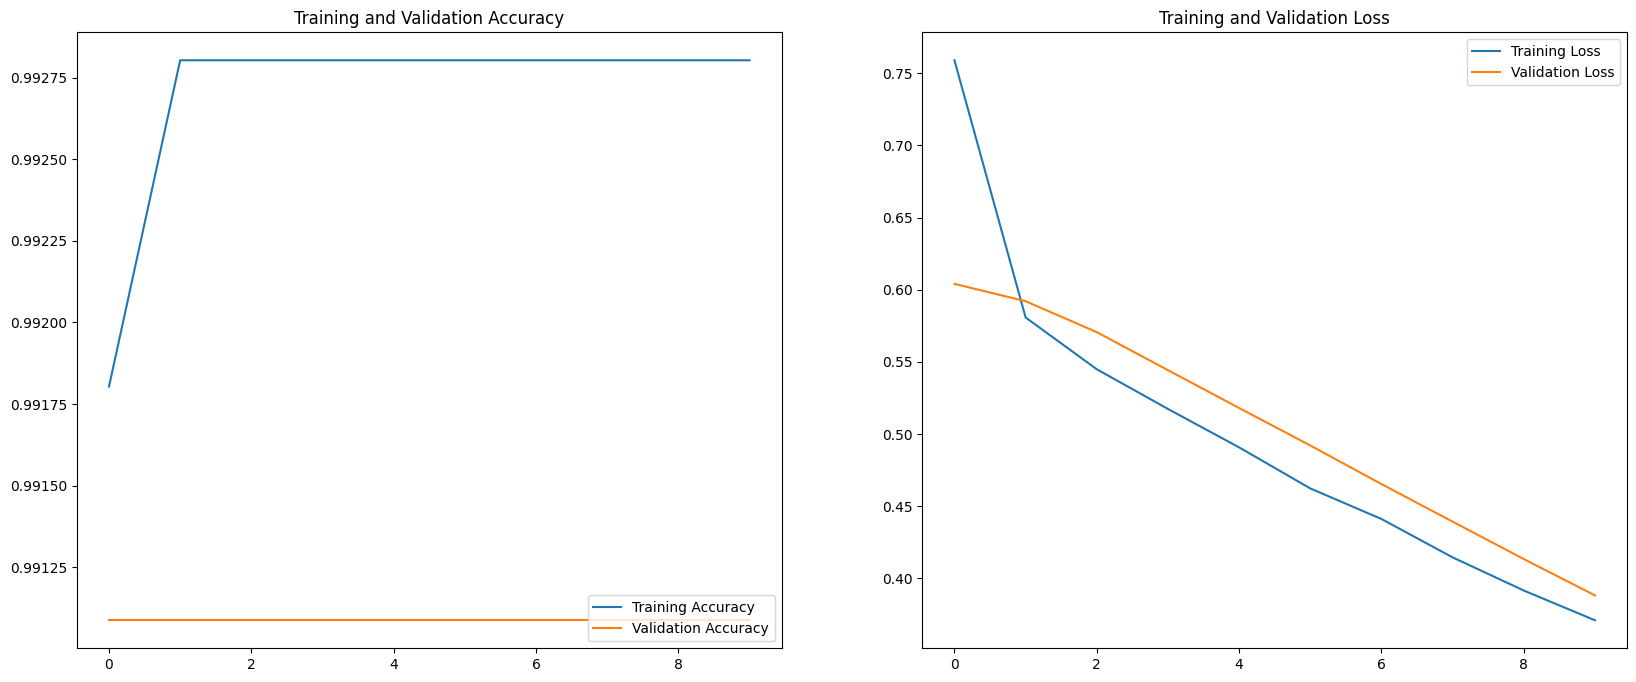

In [82]:
plot_training_results(history_v5)

18/18 [==============================] - 0s 604us/step


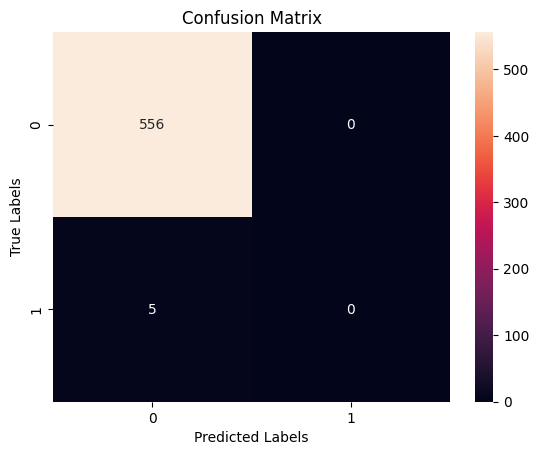

In [83]:
y_pred = np.argmax(model.predict(X_test_reduced_pca), axis=1)

cmat_(confusion_matrix(y_true=y_test_mm_scaled, 
                       y_pred=y_pred))

It seems the problem may be with our data. Let's try that same model again with our normally scaled data and see if we still get the constant validation accuracy issue.

In [84]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=64, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.25)
# dense_layer_3 = dense_layer(units=4,
#                            activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(output_layer)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                204672    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 205,729
Trainable params: 205,729
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Compile Model (Put It Together)
# optimizer = keras.optimizers.Adam(lr=10e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
optimizer = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [86]:
epochs = 10
history_v6 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = 1,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
5002/5002 [==============================] - 7s 1ms/step - loss: 1940.3363 - accuracy: 0.9612 - val_loss: 1277.1658 - val_accuracy: 0.9822
Epoch 2/10
5002/5002 [==============================] - 7s 1ms/step - loss: 1397.9591 - accuracy: 0.9902 - val_loss: 1123.6333 - val_accuracy: 0.9911
Epoch 3/10
5002/5002 [==============================] - 6s 1ms/step - loss: 1122.9841 - accuracy: 0.9920 - val_loss: 1120.3892 - val_accuracy: 0.9911
Epoch 4/10
5002/5002 [==============================] - 6s 1ms/step - loss: 1120.2178 - accuracy: 0.9924 - val_loss: 1118.5608 - val_accuracy: 0.9911
Epoch 5/10
5002/5002 [==============================] - 7s 1ms/step - loss: 1116.9663 - accuracy: 0.9928 - val_loss: 1115.3988 - val_accuracy: 0.9911
Epoch 6/10
5002/5002 [==============================] - 7s 1ms/step - loss: 1113.8319 - accuracy: 0.9926 - val_loss: 1112.2720 - val_accuracy: 0.9911
Epoch 7/10
5002/5002 [==============================] - 7s 1ms/step - loss: 1110.7125 - accuracy: 0.

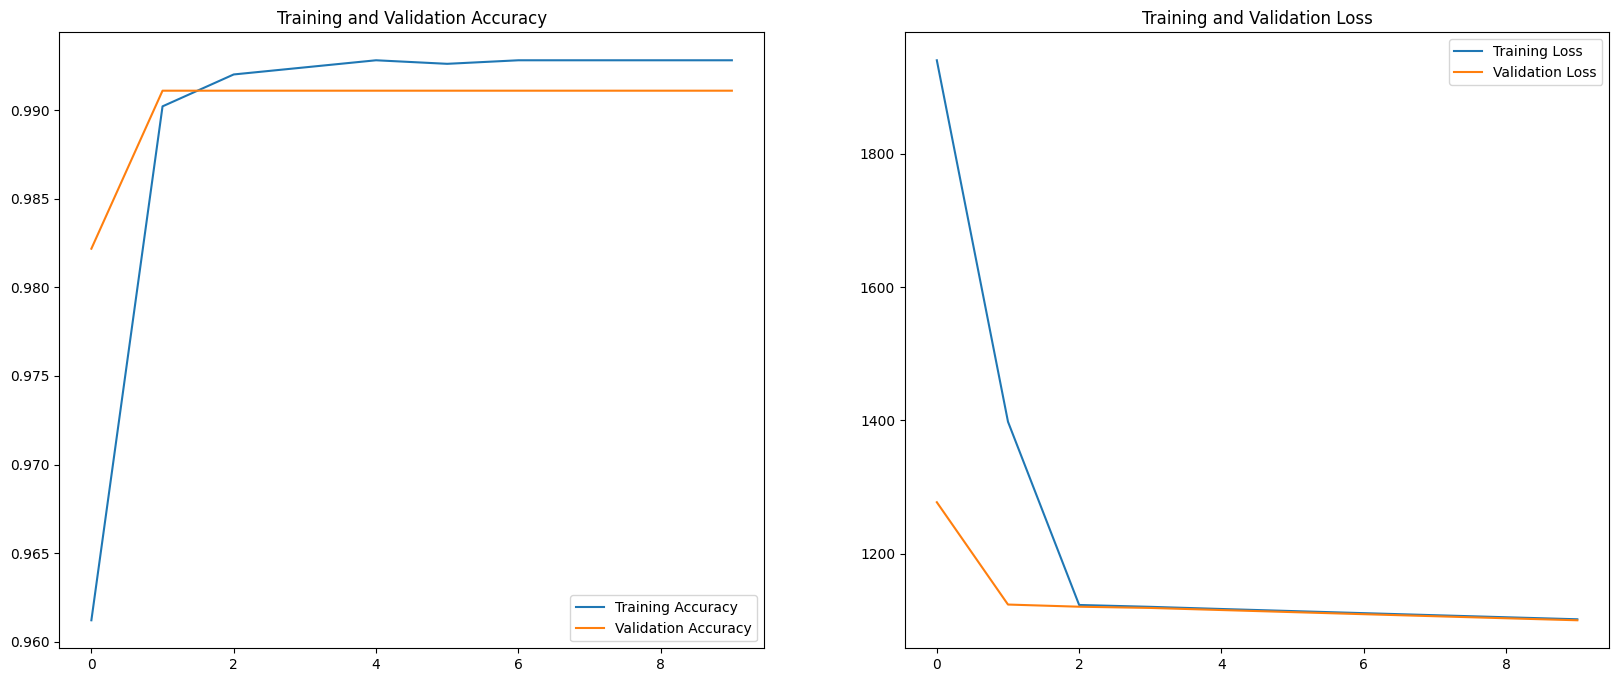

In [87]:
plot_training_results(history_v6)

18/18 [==============================] - 0s 858us/step


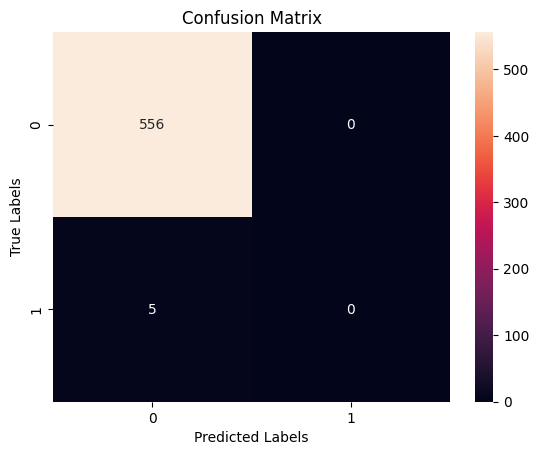

In [88]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Our training accuracy looks great! However, our validation accuracy is still unchanging.

In [89]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.75)
dense_layer_1 = dense_layer(units=128, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=64,
                           activation='relu')
dropout_2 = dropout_layer(0.5)
dense_layer_3 = dense_layer(units=8,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(dense_layer_3)
model.add(output_layer)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               409344    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 8)                 520       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 418,129
Trainable params: 418,129
Non-tr

In [90]:
optimizer = SGD(learning_rate=0.000001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [91]:
epochs = 10
history_v7 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 16.3516 - accuracy: 0.3523 - val_loss: 12.3855 - val_accuracy: 0.4795
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 15.1910 - accuracy: 0.3864 - val_loss: 11.7160 - val_accuracy: 0.5490
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 14.3336 - accuracy: 0.4300 - val_loss: 11.1890 - val_accuracy: 0.6203
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 13.2940 - accuracy: 0.4652 - val_loss: 10.7894 - val_accuracy: 0.7023
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 12.8868 - accuracy: 0.5110 - val_loss: 10.5325 - val_accuracy: 0.7487
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 11.9665 - accuracy: 0.5210 - val_loss: 10.1512 - val_accuracy: 0.7861
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 11.7656 - accuracy: 0.5492 - val_loss: 9.6892 - val_accuracy: 

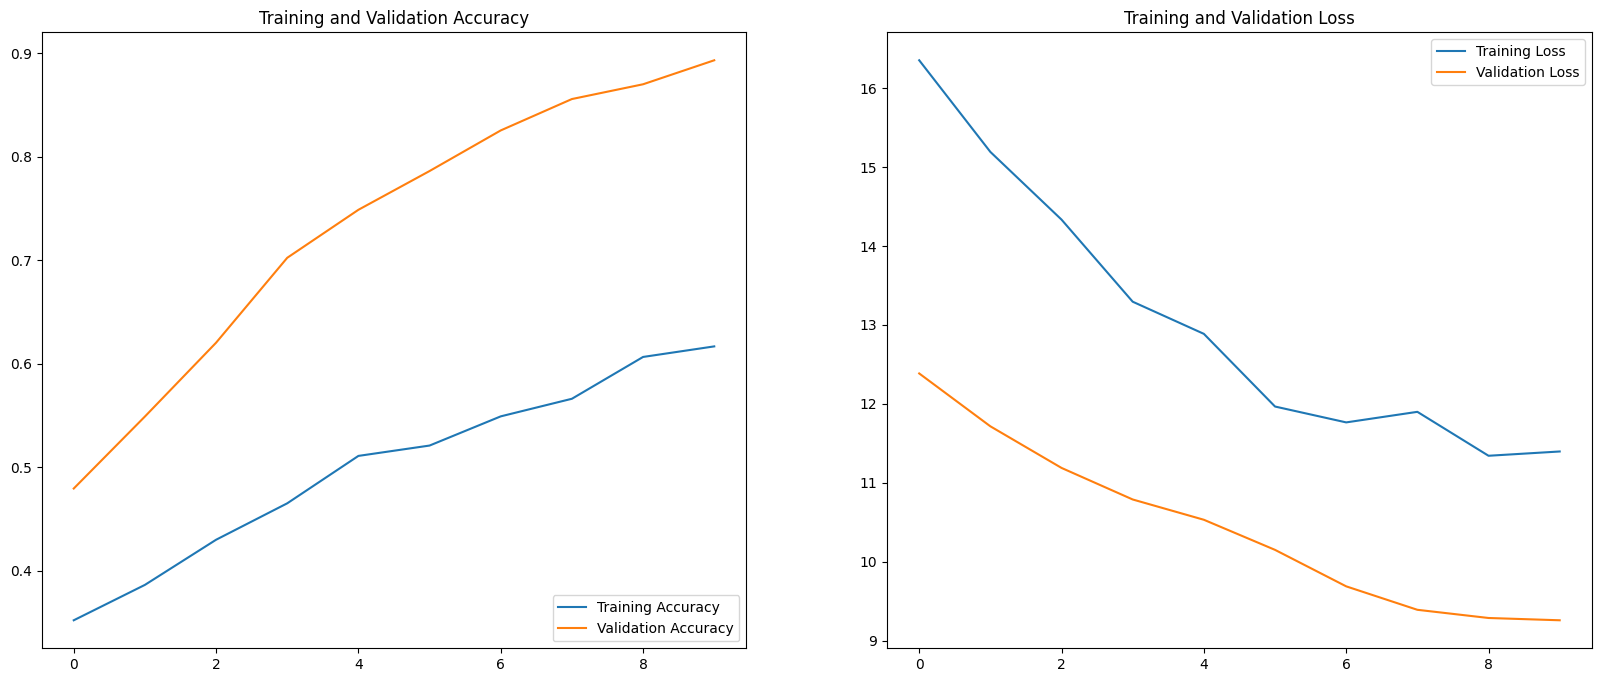

In [92]:
plot_training_results(history_v7)

18/18 [==============================] - 0s 978us/step


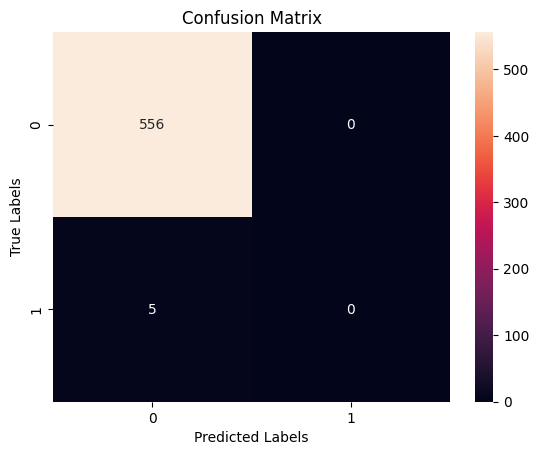

In [93]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Changing the learning rate of our optimizer helped a lot. However, it may have been too much. Let's meet in the middle with the learning rate and possibly try to change our dropout to a smaller number as well.

In [94]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=128, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=64,
                           activation='relu')
dropout_2 = dropout_layer(0.25)
dense_layer_3 = dense_layer(units=8,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(dense_layer_3)
model.add(output_layer)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               409344    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 8)                 520       
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 418,129
Trainable params: 418,129
Non-tr

In [95]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [96]:
epochs = 10
history_v8 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
157/157 [==============================] - 3s 18ms/step - loss: 9.4200 - accuracy: 0.9012 - val_loss: 9.2090 - val_accuracy: 0.9251
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 9.3387 - accuracy: 0.9362 - val_loss: 9.1044 - val_accuracy: 0.9661
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 9.1322 - accuracy: 0.9546 - val_loss: 9.0597 - val_accuracy: 0.9804
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 9.1134 - accuracy: 0.9654 - val_loss: 9.0401 - val_accuracy: 0.9875
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 9.0632 - accuracy: 0.9712 - val_loss: 9.0228 - val_accuracy: 0.9875
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 9.1006 - accuracy: 0.9726 - val_loss: 9.0074 - val_accuracy: 0.9875
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 9.0583 - accuracy: 0.9752 - val_loss: 8.9905 - val_accuracy: 0.9893
Epoch

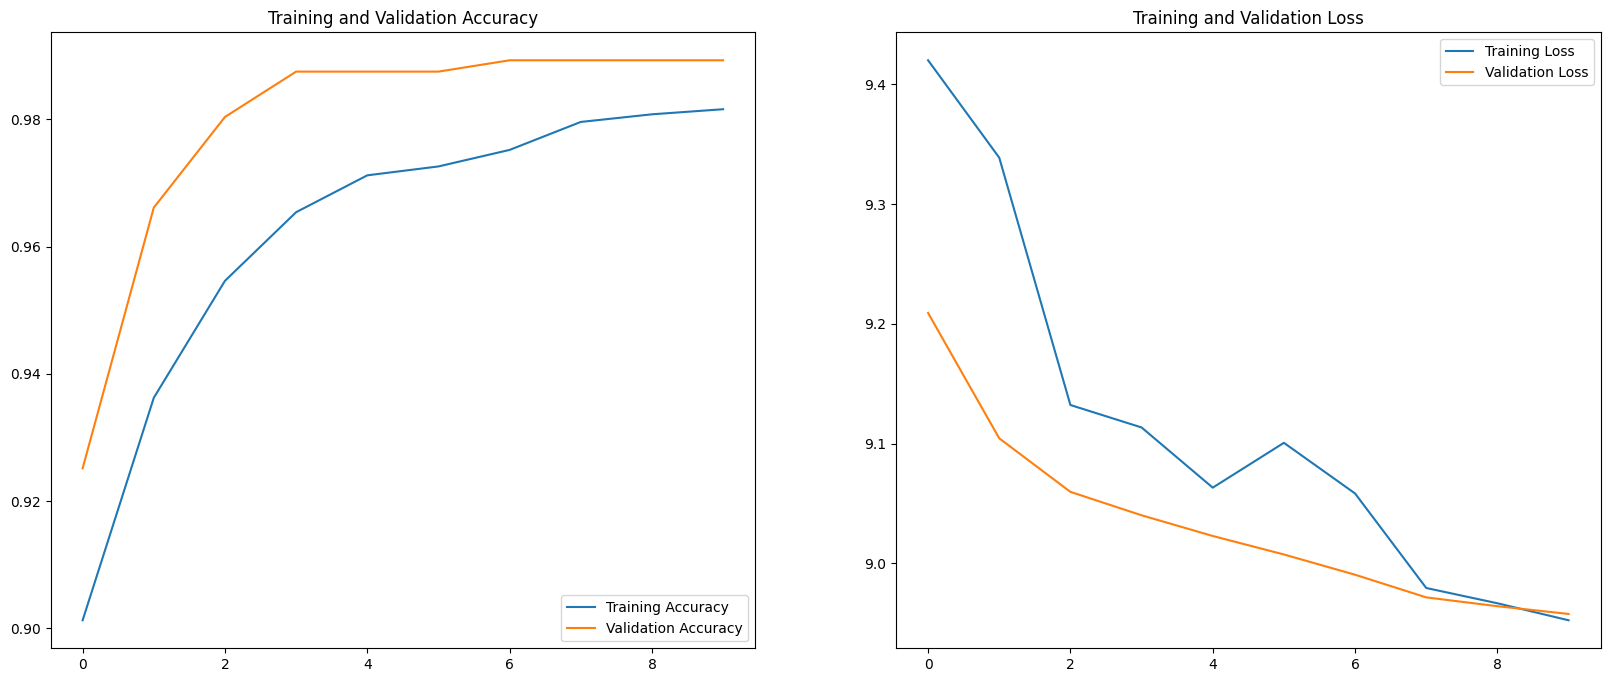

In [97]:
plot_training_results(history_v8)

18/18 [==============================] - 0s 1ms/step


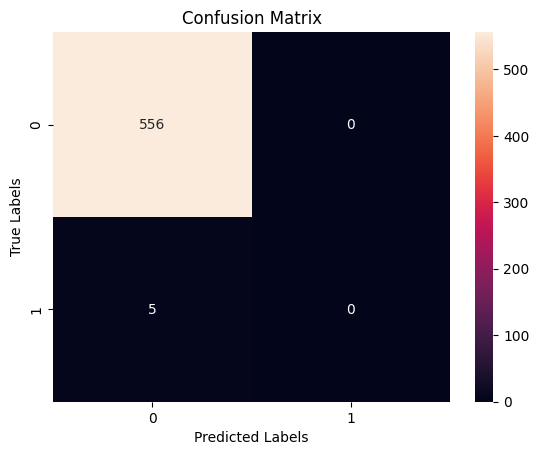

In [98]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Our accuracy functions look good!! However, our loss functions could be better, especially with validation loss. Both of the validation graphs could be better as well. However, we may not be able to improve these much because we have such a small validation dataset and this could be hindering our ability to check against our validation data. Let's try to make our model a bit simpler and see if this helps.

In [99]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=128, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=64,
                           activation='relu')
dropout_2 = dropout_layer(0.2)
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(output_layer)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 128)               409344    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 417,665
Trainable params: 417,665
Non-trainable params: 0
_________________________________________________________________


In [100]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [101]:
epochs = 10
history_v9 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 9.8949 - accuracy: 0.8181 - val_loss: 9.6570 - val_accuracy: 0.9608
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 9.2389 - accuracy: 0.9208 - val_loss: 9.4114 - val_accuracy: 0.9822
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 9.1703 - accuracy: 0.9484 - val_loss: 9.3047 - val_accuracy: 0.9857
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 9.1062 - accuracy: 0.9564 - val_loss: 9.2121 - val_accuracy: 0.9857
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 9.0779 - accuracy: 0.9696 - val_loss: 9.1358 - val_accuracy: 0.9875
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 9.0482 - accuracy: 0.9714 - val_loss: 9.1333 - val_accuracy: 0.9911
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 9.0349 - accuracy: 0.9766 - val_loss: 9.1220 - val_accuracy: 0.9911
Epoch 

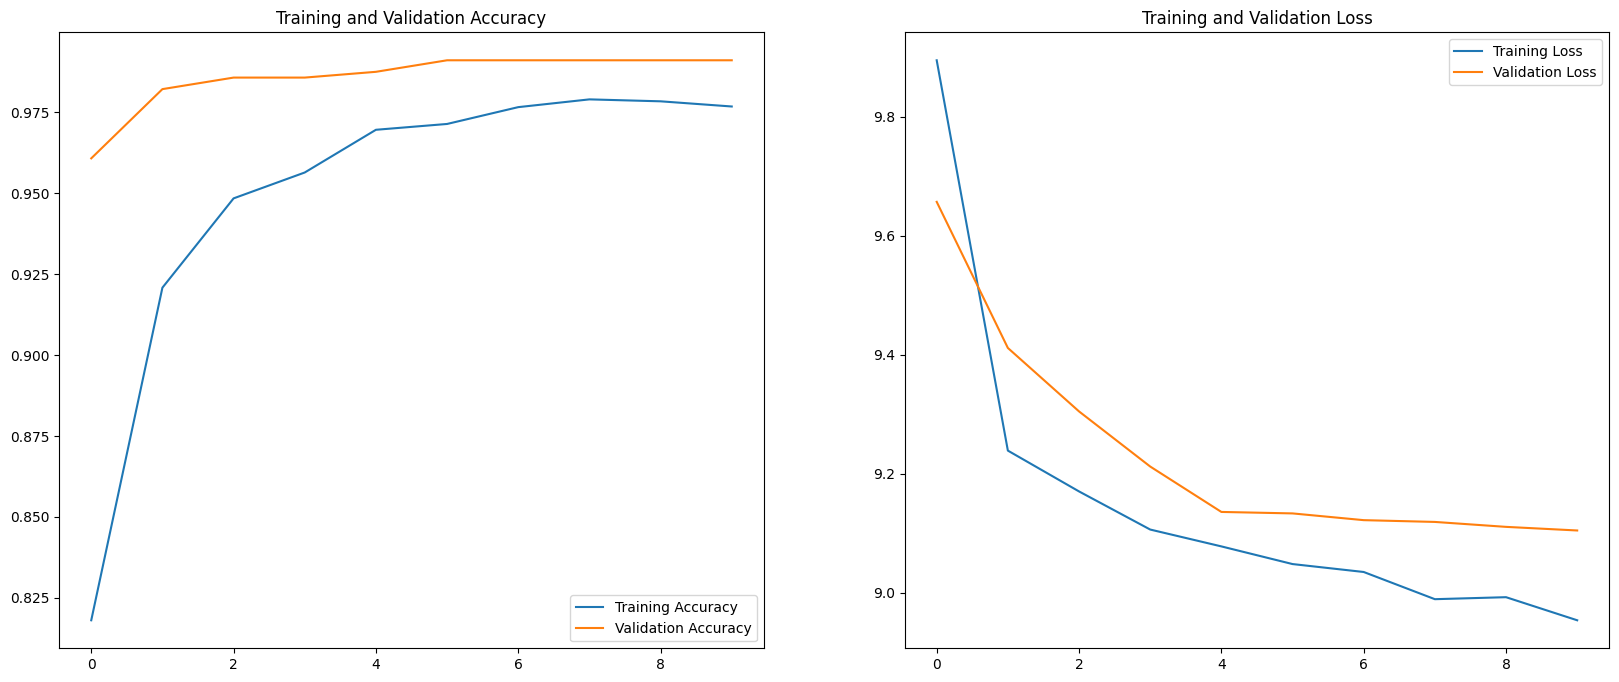

In [102]:
plot_training_results(history_v9)

18/18 [==============================] - 0s 1ms/step


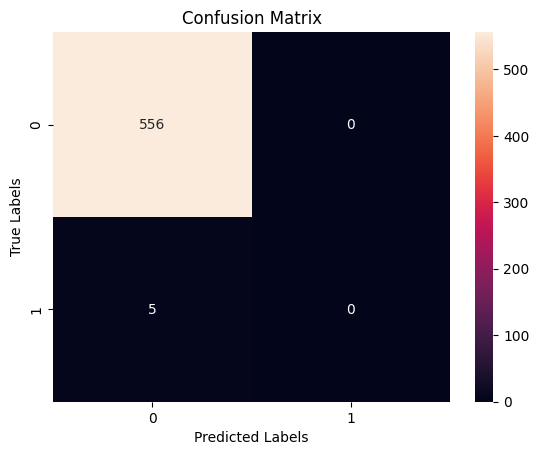

In [103]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

That made our training score look almost perfect. However, we did not do too much to our validation scores. 

In [104]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=64, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.2)
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(output_layer)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                204672    
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 16)                1040      
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 205,729
Trainable params: 205,729
Non-trainable params: 0
_________________________________________________________________


In [105]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [106]:
epochs = 10
history_v10 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 7.2776 - accuracy: 0.5086 - val_loss: 8.4114 - val_accuracy: 0.6025
Epoch 2/10
157/157 [==============================] - 0s 2ms/step - loss: 5.7785 - accuracy: 0.6483 - val_loss: 6.8720 - val_accuracy: 0.7558
Epoch 3/10
157/157 [==============================] - 0s 2ms/step - loss: 5.4884 - accuracy: 0.7235 - val_loss: 5.8312 - val_accuracy: 0.8253
Epoch 4/10
157/157 [==============================] - 0s 2ms/step - loss: 5.2867 - accuracy: 0.7855 - val_loss: 5.1868 - val_accuracy: 0.8734
Epoch 5/10
157/157 [==============================] - 0s 2ms/step - loss: 5.0845 - accuracy: 0.8237 - val_loss: 4.8671 - val_accuracy: 0.8966
Epoch 6/10
157/157 [==============================] - 0s 2ms/step - loss: 5.0014 - accuracy: 0.8493 - val_loss: 4.8149 - val_accuracy: 0.9358
Epoch 7/10
157/157 [==============================] - 0s 2ms/step - loss: 4.9741 - accuracy: 0.8776 - val_loss: 4.7803 - val_accuracy: 0.9501
Epoch 

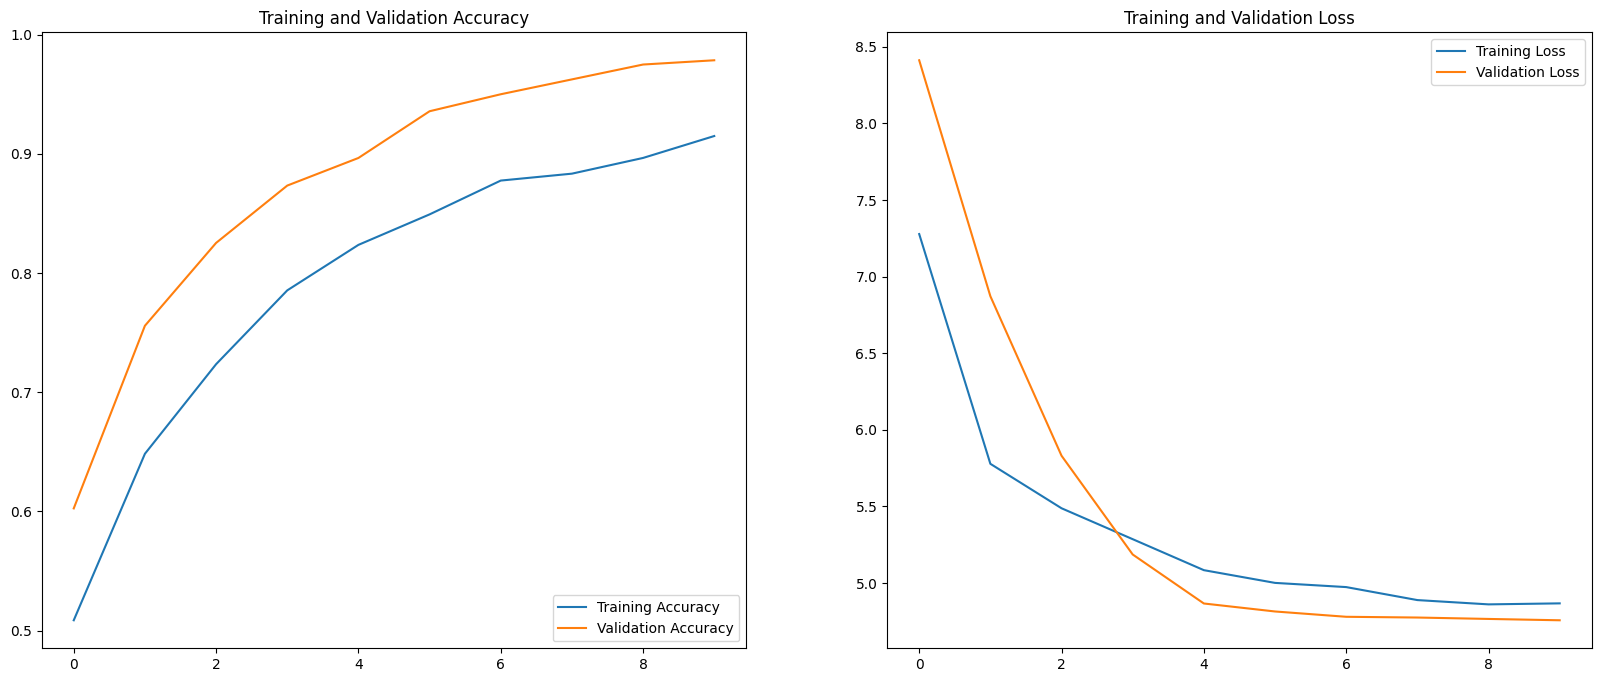

In [107]:
plot_training_results(history_v10)

18/18 [==============================] - 0s 882us/step


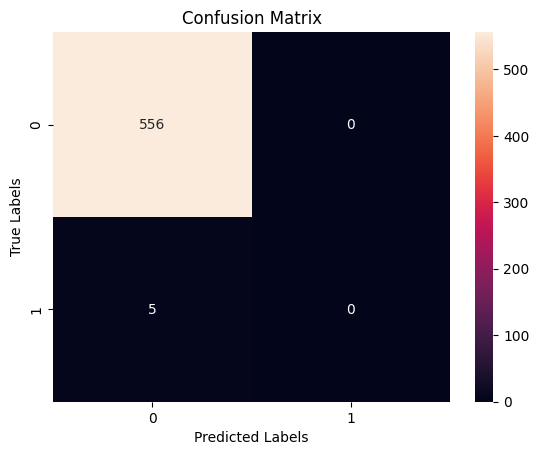

In [108]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

Better! It seemed that creating a custom optimizer with a custom very small learning rate and adding in the l1 and l2 regularization helped a lot. Also decreasing the complexity/number of trainable params of the model help to stop instant overfitting that was happening in the first dense layer. We also see from our steadily increasing accuracy that the model is not overfitting, and we still end up with a great acciracy score of 89%. However, our loss is not ideal. Ideally, we would have loss values under 0.1. This is something that definitely needs to improve. Let's trying running our model with a few more epochs to see if this can improve with more iterations.

In [109]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.5)
dense_layer_1 = dense_layer(units=64, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.2)
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
model.add(dropout_2)
model.add(output_layer)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 64)                204672    
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 16)                1040      
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 17        
                                                                 
Total params: 205,729
Trainable params: 205,729
Non-trainable params: 0
_________________________________________________________________


In [110]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [111]:
epochs = 100
history_v11 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 6.7034 - accuracy: 0.5838 - val_loss: 5.3193 - val_accuracy: 0.7825
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 5.8788 - accuracy: 0.7111 - val_loss: 4.9942 - val_accuracy: 0.8734
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 5.5911 - accuracy: 0.7623 - val_loss: 4.8433 - val_accuracy: 0.9358
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 5.2696 - accuracy: 0.8207 - val_loss: 4.8194 - val_accuracy: 0.9537
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 5.0282 - accuracy: 0.8537 - val_loss: 4.8052 - val_accuracy: 0.9608
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 4.9854 - accuracy: 0.8711 - val_loss: 4.8014 - val_accuracy: 0.9626
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 4.8998 - accuracy: 0.8898 - val_loss: 4.7986 - val_accuracy: 0.9679

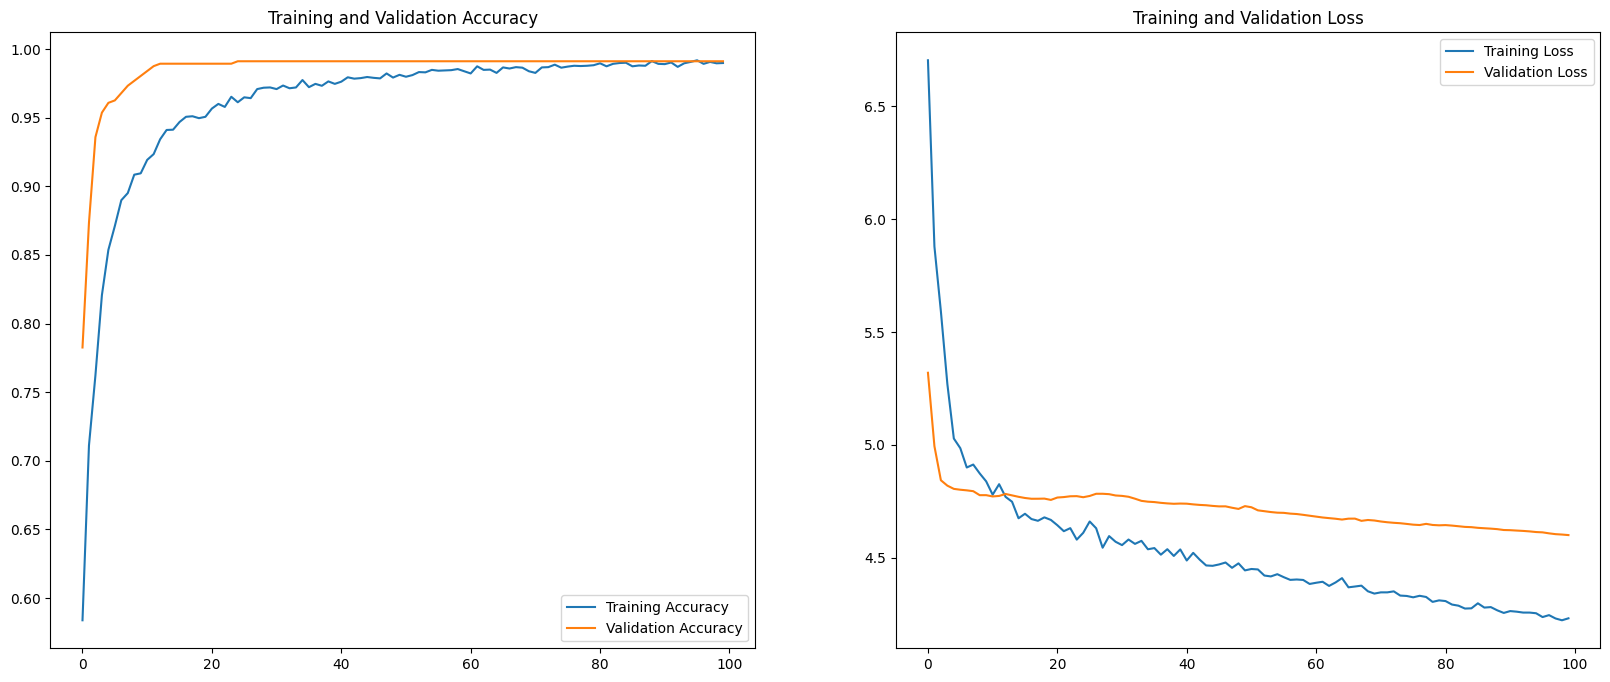

In [112]:
plot_training_results(history_v11)

18/18 [==============================] - 0s 856us/step


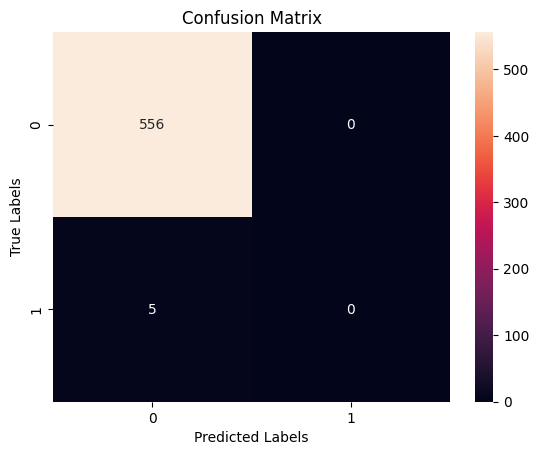

In [113]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

It doesn't seem like we can get our loss down any more using our normal model methods. This may be because our learning rate is so high. Let's first try to add another dense layer, then decrease our learning rate.

In [114]:
model = Sequential()
input_layer = keras.layers.InputLayer(input_shape=(3197,))
dropout_1 = dropout_layer(0.3)
dense_layer_1 = dense_layer(units=16, 
                          activation='relu',
                          kernel_regularizer=l1_l2(l1=0.001,
                                                   l2=0.0001))
dense_layer_2 = dense_layer(units=16,
                           activation='relu')
dropout_2 = dropout_layer(0.25)
dense_layer_3 = dense_layer(units=8,
                           activation='relu')
dropout_3 = dropout_layer(0.2)
dense_layer_4 = dense_layer(units=4,
                           activation='relu')
dense_layer_5 = dense_layer(units=4,
                           activation='relu')
output_layer = dense_layer(units=1,
                           activation='sigmoid')

model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_1)
model.add(dense_layer_2)
# model.add(dropout_2)
model.add(dense_layer_3)
model.add(dropout_3)
model.add(dense_layer_4)
model.add(dense_layer_5)
model.add(output_layer)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                51168     
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_41 (Dense)            (None, 16)                272       
                                                                 
 dense_42 (Dense)            (None, 8)                 136       
                                                                 
 dropout_22 (Dropout)        (None, 8)                 0         
                                                                 
 dense_43 (Dense)            (None, 4)                 36        
                                                                 
 dense_44 (Dense)            (None, 4)               

In [115]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [116]:
epochs = 25
history_v12 = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = 10,
    verbose = 1,
    validation_data=(X_test, y_test)
)

Epoch 1/25
501/501 [==============================] - 1s 1ms/step - loss: 1.9848 - accuracy: 0.4832 - val_loss: 2.1960 - val_accuracy: 0.5704
Epoch 2/25
501/501 [==============================] - 1s 1ms/step - loss: 1.8826 - accuracy: 0.7157 - val_loss: 1.9577 - val_accuracy: 0.7576
Epoch 3/25
501/501 [==============================] - 1s 1ms/step - loss: 1.8316 - accuracy: 0.8241 - val_loss: 1.8459 - val_accuracy: 0.8610
Epoch 4/25
501/501 [==============================] - 1s 1ms/step - loss: 1.7923 - accuracy: 0.8858 - val_loss: 1.8007 - val_accuracy: 0.9144
Epoch 5/25
501/501 [==============================] - 1s 1ms/step - loss: 1.7647 - accuracy: 0.9186 - val_loss: 1.7712 - val_accuracy: 0.9447
Epoch 6/25
501/501 [==============================] - 1s 1ms/step - loss: 1.7396 - accuracy: 0.9344 - val_loss: 1.7465 - val_accuracy: 0.9501
Epoch 7/25
501/501 [==============================] - 1s 1ms/step - loss: 1.7263 - accuracy: 0.9440 - val_loss: 1.7205 - val_accuracy: 0.9554
Epoch 

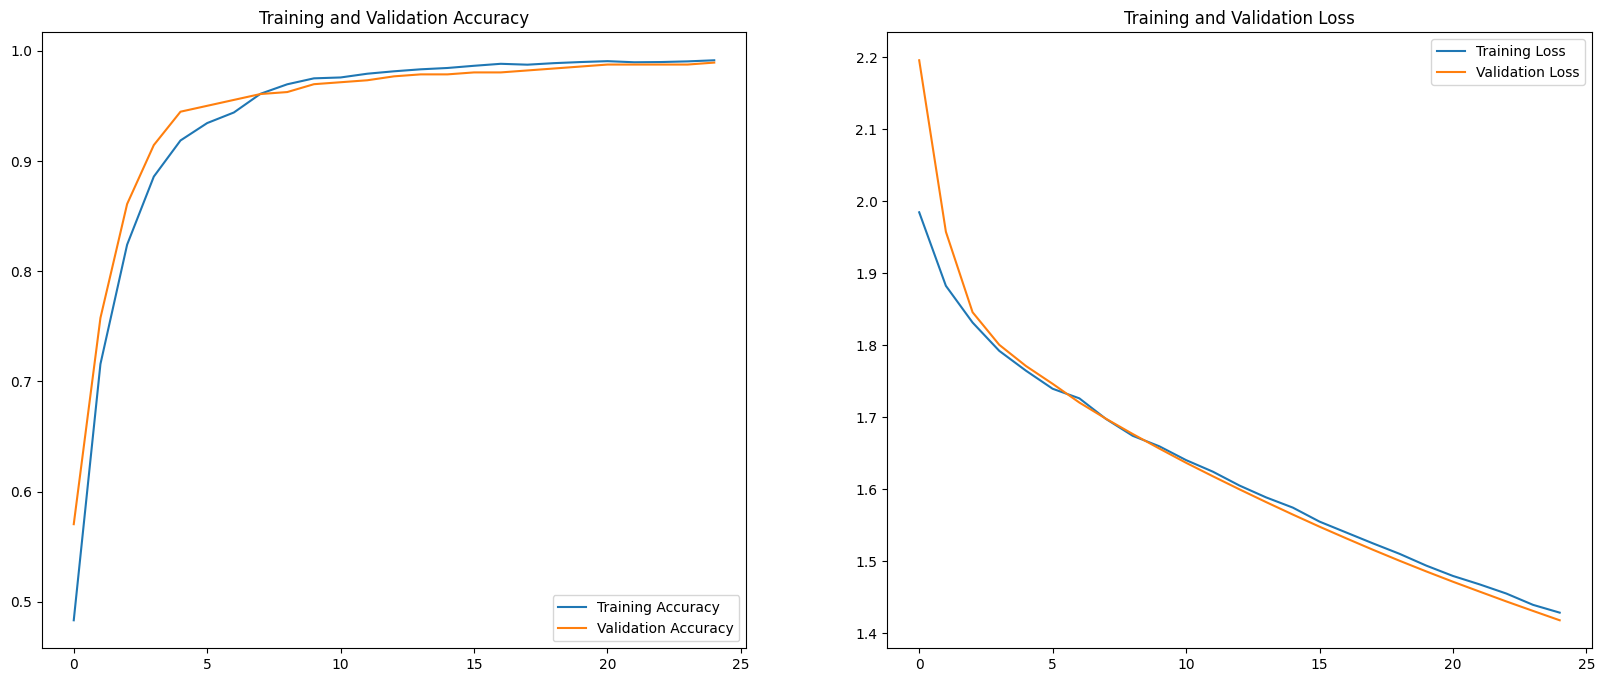

In [117]:
plot_training_results(history_v12)

This seems to be doing better. Let's look at a confusion matrix to see when it predicted one class, and was either right or wrong.

18/18 [==============================] - 0s 795us/step


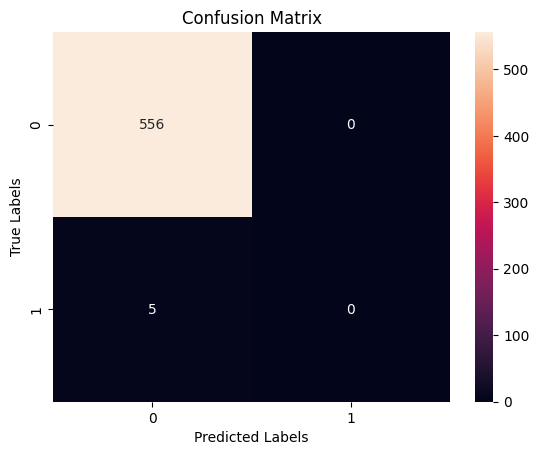

In [118]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cmat_(confusion_matrix(y_true=y_test, 
                       y_pred=y_pred))

By changing batch size, epochs, and a few layers, we were able to get the loss down to around 1. However, this still is not ideal. Overall, we definitely need more data for a model like this. Ideally, we have two options for creating a good model. We could perform intense hyperparameter tuning on a machine learning model to make sure it is not overfitting the data (something that is easier to do with ANNs). We could also get more data, which is available but very time consuming to download, process, and label. However, with more data we could make these ANN models that are already performing very well do even better.

### Reflection

Overall, any neural network or really any machine learning model will not have great predictive scores because we do not have enough data to really predict on. We also do not have enough to train on either. While it seems that our models may be okay due to their high accuracy scores, the loss scores are always over 100% meaning there is no model that can predict on our data. 

A good future step to take would be figuring out how to get more data. The limited availability of this specific data is due to the manual nature of collecting it. If we wanted to add more data, we would have to download the light curves from Kepler/TESS, which is not extremely accessible and requires the knowledge of an astrophycist to know which data products are teh correct ones to download. The process of bulk downloading data is also not extremely straightforward, so more research would need to be done to bulk download these light curves. And the most tedious part would be labeling light curves as an exoplanet detection or no exoplanet detection manually. 

For future steps, it would be ideal to build some sort of data pipeline that can download the correct data, then find some sort of descriptive feature, perhaps ICRS coordinates of the observation, and find a database accessible from Astropy that will be able to take the descriptive feature and see if there was an exoplanet detection or not. More research would need ot be done on the features included with this light curve data, a descriptive feature that could be matched in a database, the database to search, and how a label would be determined from this search. If the process could be automated, it would expedite the process and help immensely.

Overall, we were able to start cutting down on our loss metrics and make sure our accuracy and loss metrics increased/decreased in the way we wanted them to. However, without more data, overfitting is very hard to prevent and predicting will not be accurate. 